In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import scipy.signal
import sys
%matplotlib inline
import scipy as sp
import time
start_time = time.time()

In [2]:
# Imports auxiliary functions
import importlib

import StrucFunction
importlib.reload(StrucFunction)
from StrucFunction import *

import structfunc2KEflux
importlib.reload(structfunc2KEflux)
from structfunc2KEflux import *

# Loads Drifter's Trajectory data from Balwada et al. (2022) code

### GLAD: Summer experiment (90 days)
### LASER: Winter experiment (60 days)

In [3]:
import pickle

# Loads trajectories
with open('./traj_mat_GLAD_15min_04_May_2021.pkl', 'rb') as f:
    glad_traj = pickle.load(f)

with open('./traj_mat_LASER_15min_04_May_2021.pkl', 'rb') as f:
    laser_traj = pickle.load(f)

glad_x = glad_traj['trajmat_X']
glad_y = glad_traj['trajmat_Y']
laser_x = laser_traj['trajmat_X']
laser_y = laser_traj['trajmat_Y']

In [4]:
# In-plot boxes
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

In [ ]:
#### Plots area of study
import os
import cmocean
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator, LongitudeLocator)
cartopy.config['data_dir'] = os.getenv('CARTOPY_DIR', cartopy.config.get('data_dir'))

# Box limits
lonmin = -84
lonmax = -91
latmin = 24
latmax = 30

# Defining the figure
fg0, a0 = plt.subplots(1, 2, sharex=True, sharey=True,
                         figsize=(7, 7.3),
                         facecolor='w', edgecolor='k',
                         subplot_kw={'projection': ccrs.PlateCarree()})
fg0.subplots_adjust(wspace=0.3, hspace=0.02)

cs = np.linspace(0, 1.4, 50)

a0[0].set_extent([-97, -83, 18, 32], ccrs.PlateCarree())     
a0[0].plot(glad_x, glad_y, linewidth=0.5)
a0[0].plot([lonmin, lonmin, lonmax, lonmax, lonmin], [latmin, latmax, latmax, latmin, latmin], 
           linewidth=1, color='black', transform=ccrs.PlateCarree())
a0[0].text(0.1, 0.95, 'a) GLAD (summer)', transform=a0[0].transAxes, fontsize=10,
           verticalalignment='top', bbox=props)
a0[0].yaxis.tick_left()
a0[0].set_xticks(np.arange(-98, -83, 4), crs=ccrs.PlateCarree())
a0[0].set_yticks(np.arange(18, 32, 3), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
a0[0].xaxis.set_major_formatter(lon_formatter)
a0[0].yaxis.set_major_formatter(lat_formatter)
a0[0].set_xlabel('')
a0[0].set_ylabel('')
a0[0].set_title('')
a0[0].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'))
a0[0].coastlines(linewidth=1)

a0[1].set_extent([-97, -83, 18, 32], ccrs.PlateCarree())     
a0[1].plot(laser_x, laser_y, linewidth=0.5)
a0[1].plot([lonmin, lonmin, lonmax, lonmax, lonmin], [latmin, latmax, latmax, latmin, latmin], 
           linewidth=1, color='black', transform=ccrs.PlateCarree())
a0[1].text(0.1, 0.95, 'b) LASER (winter)', transform=a0[1].transAxes, fontsize=10,
           verticalalignment='top', bbox=props)
a0[1].yaxis.tick_right()
a0[1].set_xticks(np.arange(-98, -83, 4), crs=ccrs.PlateCarree())
a0[1].set_yticks(np.arange(18, 32, 3), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
a0[1].xaxis.set_major_formatter(lon_formatter)
a0[1].yaxis.set_major_formatter(lat_formatter)
a0[1].set_xlabel('')
a0[1].set_ylabel('')
a0[1].set_title('')
a0[1].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'))
a0[1].coastlines(linewidth=1)

fg0.tight_layout(pad=0.001)

fg0.savefig('./FiguresMethodsPaper/fig_trajdrifters.png', bbox_inches = 'tight', format='png', dpi=500)

# Loads binned pairwise velocity fluctuation data

### GLAD: summertime experiment (60 days)

### LASER: wintertime experiment (90 days)

In [104]:
# Indices
indi = 5
indf = 28
# Load GLAD pairs_sep
with open('./pairs_sep_GLAD.pkl', 'rb') as f:
    glad_all = pickle.load(f)

glad_dul = glad_all['dul'][indi:indf]
glad_dut = glad_all['dut'][indi:indf]
dist_all = glad_all['dist_axis'][indi:indf]

# Load LASER pairs_sep
with open('./pairs_sep_LASER.pkl', 'rb') as f:
    laser_all = pickle.load(f)

laser_dul = laser_all['dul'][indi:indf]
laser_dut = laser_all['dut'][indi:indf]

In [286]:
from scipy.stats import kurtosis, skew
from joblib import Parallel, delayed  # For parallel processing

# Function to calculate the necessary statistics
def calculate_stats(du_glad, du_laser, du2_glad, du2_laser, du3_glad, du3_laser):
    glad_stats = {
        'mean': np.mean(du_glad),
        'std': np.std(du_glad),
        'skew': skew(du_glad),
        'kurt': kurtosis(du_glad, fisher=True)
    }
    
    laser_stats = {
        'mean': np.mean(du_laser),
        'std': np.std(du_laser),
        'skew': skew(du_laser),
        'kurt': kurtosis(du_laser, fisher=True)
    }

    glad_du2_stats = {
        'mean': np.mean(du2_glad),
        'std': np.std(du2_glad),
        'skew': skew(du2_glad),
        'kurt': kurtosis(du2_glad, fisher=True)
    }

    laser_du2_stats = {
        'mean': np.mean(du2_laser),
        'std': np.std(du2_laser),
        'skew': skew(du2_laser),
        'kurt': kurtosis(du2_laser, fisher=True)
    }

    glad_du3_stats = {
        'mean': np.mean(du3_glad),
        'std': np.std(du3_glad),
        'skew': skew(du3_glad),
        'kurt': kurtosis(du3_glad, fisher=True)
    }

    laser_du3_stats = {
        'mean': np.mean(du3_laser),
        'std': np.std(du3_laser),
        'skew': skew(du3_laser),
        'kurt': kurtosis(du3_laser, fisher=True)
    }

    return glad_stats, laser_stats, glad_du2_stats, laser_du2_stats, glad_du3_stats, laser_du3_stats


# Parallelize the processing of each index
def process_index(ii):
    du_glad = glad_dul[ii] + glad_dut[ii]
    du_laser = laser_dul[ii] + laser_dut[ii]
    
    du2_glad, du3_glad = SF2_3(glad_dul[ii], glad_dut[ii])
    du2_laser, du3_laser = SF2_3(laser_dul[ii], laser_dut[ii])

    return calculate_stats(du_glad, du_laser, du2_glad, du2_laser, du3_glad, du3_laser)

In [287]:
num_cores = 6  # use all available cores
results = Parallel(n_jobs=num_cores, backend="threading")(
    delayed(process_index)(ii) for ii in tqdm(range(len(dist_all)))
)

# Convert results to structured NumPy arrays in one go
results = list(zip(*results))  # unzip once
glad_stats_all, laser_stats_all, glad_du2_stats_all, laser_du2_stats_all, glad_du3_stats_all, laser_du3_stats_all = results

def stack_stats(stats_list):
    """Convert list of dicts to stacked arrays: mean, std, skew, kurt"""
    return np.stack([s['mean'] for s in stats_list]), \
           np.stack([s['std'] for s in stats_list]), \
           np.stack([s['skew'] for s in stats_list]), \
           np.stack([s['kurt'] for s in stats_list])

# Extract all at once
glad_du_mean, glad_du_std, glad_du_skew, glad_du_kurt = stack_stats(glad_stats_all)
laser_du_mean, laser_du_std, laser_du_skew, laser_du_kurt = stack_stats(laser_stats_all)

glad_du2_mean, glad_du2_std, glad_du2_skew, glad_du2_kurt = stack_stats(glad_du2_stats_all)
laser_du2_mean, laser_du2_std, laser_du2_skew, laser_du2_kurt = stack_stats(laser_du2_stats_all)

glad_du3_mean, glad_du3_std, glad_du3_skew, glad_du3_kurt = stack_stats(glad_du3_stats_all)
laser_du3_mean, laser_du3_std, laser_du3_skew, laser_du3_kurt = stack_stats(laser_du3_stats_all)

  0%|          | 0/23 [00:00<?, ?it/s]

In [9]:
# # Define number of CPU cores for parallelism
# num_cores = 10  # Using all available cores (-1), you can set it to a specific number if preferred

# # Using Parallel and delayed from joblib to process in parallel
# results = Parallel(n_jobs=num_cores)(delayed(process_index)(ii) for ii in tqdm(range(len(dist_all))))

# # Unpack results and store them in respective arrays
# glad_du_mean, laser_du_mean = [], []
# glad_du_std, laser_du_std = [], []
# glad_du_skew, laser_du_skew = [], []
# glad_du_kurt, laser_du_kurt = [], []
# glad_du2_mean, laser_du2_mean = [], []
# glad_du2_std, laser_du2_std = [], []
# glad_du2_skew, laser_du2_skew = [], []
# glad_du2_kurt, laser_du2_kurt = [], []
# glad_du3_mean, laser_du3_mean = [], []
# glad_du3_std, laser_du3_std = [], []
# glad_du3_skew, laser_du3_skew = [], []
# glad_du3_kurt, laser_du3_kurt = [], []

# # Extract values from results and store them in arrays
# for glad_stats, laser_stats, glad_du2_stats, laser_du2_stats, glad_du3_stats, laser_du3_stats in results:
#     glad_du_mean.append(glad_stats['mean'])
#     laser_du_mean.append(laser_stats['mean'])
#     glad_du_std.append(glad_stats['std'])
#     laser_du_std.append(laser_stats['std'])
#     glad_du_skew.append(glad_stats['skew'])
#     laser_du_skew.append(laser_stats['skew'])
#     glad_du_kurt.append(glad_stats['kurt'])
#     laser_du_kurt.append(laser_stats['kurt'])
    
#     glad_du2_mean.append(glad_du2_stats['mean'])
#     laser_du2_mean.append(laser_du2_stats['mean'])
#     glad_du2_std.append(glad_du2_stats['std'])
#     laser_du2_std.append(laser_du2_stats['std'])
#     glad_du2_skew.append(glad_du2_stats['skew'])
#     laser_du2_skew.append(laser_du2_stats['skew'])
#     glad_du2_kurt.append(glad_du2_stats['kurt'])
#     laser_du2_kurt.append(laser_du2_stats['kurt'])
    
#     glad_du3_mean.append(glad_du3_stats['mean'])
#     laser_du3_mean.append(laser_du3_stats['mean'])
#     glad_du3_std.append(glad_du3_stats['std'])
#     laser_du3_std.append(laser_du3_stats['std'])
#     glad_du3_skew.append(glad_du3_stats['skew'])
#     laser_du3_skew.append(laser_du3_stats['skew'])
#     glad_du3_kurt.append(glad_du3_stats['kurt'])
#     laser_du3_kurt.append(laser_du3_stats['kurt'])

# # Convert the lists to numpy arrays for further use
# glad_du_mean = np.array(glad_du_mean)
# laser_du_mean = np.array(laser_du_m"ean)
# glad_du_std = np.array(glad_du_std)
# laser_du_std = np.array(laser_du_std)
# glad_du_skew = np.array(glad_du_skew)
# laser_du_skew = np.array(laser_du_skew)
# glad_du_kurt = np.array(glad_du_kurt)
# laser_du_kurt = np.array(laser_du_kurt)

# glad_du2_mean = np.array(glad_du2_mean)
# laser_du2_mean = np.array(laser_du2_mean)
# glad_du2_std = np.array(glad_du2_std)
# laser_du2_std = np.array(laser_du2_std)
# glad_du2_skew = np.array(glad_du2_skew)
# laser_du2_skew = np.array(laser_du2_skew)
# glad_du2_kurt = np.array(glad_du2_kurt)
# laser_du2_kurt = np.array(laser_du2_kurt)

# glad_du3_mean = np.array(glad_du3_mean)
# laser_du3_mean = np.array(laser_du3_mean)
# glad_du3_std = np.array(glad_du3_std)
# laser_du3_std = np.array(laser_du3_std)
# glad_du3_skew = np.array(glad_du3_skew)
# laser_du3_skew = np.array(laser_du3_skew)
# glad_du3_kurt = np.array(glad_du3_kurt)
# laser_du3_kurt = np.array(laser_du3_kurt)

# Calculates first-order structure function $D1(r)$

#### Homogeneity condition: $D1(r)\sim 0$ 

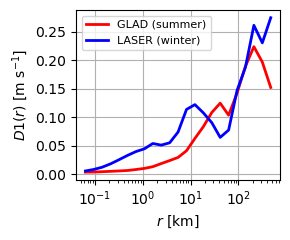

In [122]:
fig3, ax3 = plt.subplots(1, 1, figsize=(3, 2.5))

# du_mbins = 0.5*(du_bins[:-1] + du_bins[1:])
# ddu = np.mean(np.diff((du_mbins), axis=0))

distkm = dist_all*1e-3

ax3.semilogx(distkm, glad_du_mean, '-r', linewidth=2, label='GLAD (summer)')
ax3.plot(distkm, laser_du_mean, '-b', linewidth=2, label='LASER (winter)')
ax3.set_xlabel('$r$ [km]')
ax3.set_ylabel('$D1(r)$ [m s$^{-1}$]')
# ax3.text(0.13, 0.88, 'a)', transform=ax3.transAxes, bbox=props)
ax3.legend(fontsize=8, loc=2)
ax3.set_xticks([1e-1, 1e0, 1e1, 1e2])
ax3.grid()

# ax3[1].semilogx(distkm, glad_du_skew, '-r', linewidth=2)
# ax3[1].plot(distkm, laser_du_skew, '-b', linewidth=2)
# ax3[1].set_ylabel('$\\delta u1(r)$ Skewness')
# ax3[1].set_xlabel('$r$ [km]')
# ax3[1].text(0.13, 0.88, 'b)', transform=ax3[1].transAxes, bbox=props)
# ax3[1].set_xticks([1e-1, 1e0, 1e1, 1e2])
# ax3[1].grid()

# ax3[2].loglog(distkm, glad_du_kurt, '-r', linewidth=2)
# ax3[2].plot(distkm, laser_du_kurt, '-b', linewidth=2)
# ax3[2].set_ylabel('$\\delta u1(r)$ Kurtosis')
# ax3[2].set_xlabel('$r$ [km]')
# ax3[2].text(0.13, 0.88, 'c)', transform=ax3[2].transAxes, bbox=props)
# ax3[2].set_xticks([1e-1, 1e0, 1e1, 1e2])
# ax3[2].grid()

fig3.tight_layout()
# fig3.savefig('./FiguresMethodsPaper/fig_du1_meanskew_drifter_N.png', bbox_inches = 'tight', format='png', dpi=500)
fig3.savefig('./FiguresMethodsPaper/fig_du1_mean_drifter_N.png', bbox_inches = 'tight', format='png', dpi=500)

# Estimates Rossby number, decorrelation time scale and degrees of freedom

\begin{equation}
    Ro(r) = \frac{\sqrt{D2(r)}}{fr}
\end{equation}


\begin{equation}
    T_{scale}(r) = \frac{r}{\sqrt{D2(r)}}
\end{equation}

\begin{equation}
    N(r) =\frac{T_{scale}(r)}{T_{tot}}
\end{equation}

In [11]:
import gsw

fcor = gsw.f(27) # Coriolis
Ttot_glad = 90*86400 # Total time GLAD in seconds
Ttot_laser = 60*86400 # Total time LASER in seconds

# T_scale
tcorr_glad = timescale(glad_du2_mean, dist_all)
tcorr_laser = timescale(laser_du2_mean, dist_all)

# Ro
ro_glad = rossby_r(glad_du2_mean, dist_all, fcor)
ro_laser = rossby_r(laser_du2_mean, dist_all, fcor)

# N
dof_glad = Ttot_glad/tcorr_glad
dof_laser = Ttot_laser/tcorr_laser

In [211]:
# fig2, ax2 = plt.subplots(1, 3, figsize=(9, 2.5), sharex=True)

# distkm = dist_all*1e-3

# ax2[0].loglog(distkm, glad_du2_mean, 'r', label='GLAD (summer)')
# ax2[0].loglog(distkm, laser_du2_mean, 'b', label='LASER (winter)')
# ax2[0].set_ylabel('$D2(r)$ [m$^2$ s$^{-2}$]')
# ax2[0].plot(np.arange(1e-2, 1e3, 10), np.arange(1e-2, 1e3, 10)**(2)/(1e2), '--', linewidth=1, color='gray')
# ax2[0].plot(np.arange(1e-2, 1e3, 10), np.arange(1e-2, 1e3, 10)/1.4e2, '--', linewidth=1, color='gray')
# ax2[0].plot(np.arange(1e-2, 1e3, 10), np.arange(1e-2, 1e3, 10)**(2/3)/1.4e2, '--', linewidth=1, color='gray')
# ax2[0].text(4, 3e-1, '$r^2$')
# ax2[0].text(0.6e2, 3e-1, '$r$')
# ax2[0].text(3e2, 3e-1, '$r^{2/3}$')
# ax2[0].set_xlim(3e-2, 1e3)
# ax2[0].set_ylim(1e-4, 1e0)
# ax2[0].legend(fontsize=8)
# ax2[0].text(0.1, 0.87, 'a)', transform=ax2[0].transAxes, bbox=props)
# ax2[0].set_xlabel('$r$ [km]')

# ax2[1].loglog(distkm, tcorr_glad/86400, 'r')
# ax2[1].loglog(distkm, tcorr_laser/86400, 'b')
# ax2[1].set_xlabel('$r$ [km]')
# ax2[1].set_ylabel('$T_{scale}(r)$ [days]')
# ax2[1].text(0.1, 0.87, 'b)', transform=ax2[1].transAxes, bbox=props)


# ax2[2].loglog(distkm, dof_glad, 'r')
# ax2[2].loglog(distkm, dof_laser, 'b')
# ax2[2].set_xlabel('$r$ [km]')
# ax2[2].set_ylabel('$N(r)$')
# ax2[2].text(0.1, 0.87, 'c)', transform=ax2[2].transAxes, bbox=props)
# ax2[2].set_ylim(4e0, 1e4)

# fig2.tight_layout()
# fig2.savefig('./FiguresMethodsPaper/fig_du2_drifter_N.png', bbox_inches = 'tight', format='png', dpi=500)


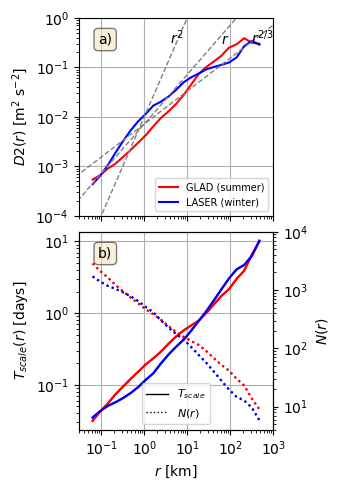

In [234]:
fig2, ax2 = plt.subplots(2, 1, figsize=(3.5, 5), sharex=True)

distkm = dist_all*1e-3

# --- Subplot 1: D2(r) ---
ax2[0].loglog(distkm, glad_du2_mean, 'r', label='GLAD (summer)')
ax2[0].loglog(distkm, laser_du2_mean, 'b', label='LASER (winter)')
ax2[0].set_ylabel('$D2(r)$ [m$^2$ s$^{-2}$]')
ax2[0].plot(np.arange(1e-2, 1e3, 10), np.arange(1e-2, 1e3, 10)**(2)/(1e2), '--', linewidth=1, color='gray')
ax2[0].plot(np.arange(1e-2, 1e3, 10), np.arange(1e-2, 1e3, 10)/1.4e2, '--', linewidth=1, color='gray')
ax2[0].plot(np.arange(1e-2, 1e3, 10), np.arange(1e-2, 1e3, 10)**(2/3)/1.4e2, '--', linewidth=1, color='gray')
ax2[0].text(4, 3e-1, '$r^2$')
ax2[0].text(0.6e2, 3e-1, '$r$')
ax2[0].text(3e2, 3e-1, '$r^{2/3}$')
ax2[0].set_xlim(3e-2, 1e3)
ax2[0].set_ylim(1e-4, 1e0)
ax2[0].legend(fontsize=7)
ax2[0].text(0.1, 0.87, 'a)', transform=ax2[0].transAxes, bbox=props)
# ax2[0].set_xlabel('$r$ [km]')
ax2[0].grid()

# --- Subplot 2: T_scale(r) with N(r) on secondary y-axis ---
ax2[1].loglog(distkm, tcorr_glad/86400, 'r', label='$T_{scale}$ GLAD')
ax2[1].loglog(distkm, tcorr_laser/86400, 'b', label='$T_{scale}$ LASER')
ax2[1].set_xlabel('$r$ [km]')
ax2[1].set_ylabel('$T_{scale}(r)$ [days]', color='k')
ax2[1].tick_params(axis='y', labelcolor='k')
ax2[1].text(0.1, 0.87, 'b)', transform=ax2[1].transAxes, bbox=props)

# Secondary y-axis for N(r)
ax2_1_sec = ax2[1].twinx()
ax2_1_sec.loglog(distkm, dof_glad, 'r', linestyle=':', label='$N(r)$ GLAD')
ax2_1_sec.loglog(distkm, dof_laser, 'b', linestyle=':', label='$N(r)$ LASER')
ax2_1_sec.set_ylabel('$N(r)$', color='k')
ax2_1_sec.tick_params(axis='y', labelcolor='k')
ax2_1_sec.set_ylim(4e0, 1e4)
ax2[1].grid()

# Plot T_scale lines
line1, = ax2[1].loglog(distkm, tcorr_glad/86400, 'r')  # only this line gets the label
line2, = ax2[1].loglog(distkm, tcorr_laser/86400, 'b')  # no label

# Plot N(r) lines on secondary y-axis
line3, = ax2_1_sec.loglog(distkm, dof_glad, 'r', linestyle=':')  # only this line gets label
line4, = ax2_1_sec.loglog(distkm, dof_laser, 'b', linestyle=':')  # no label

# Create custom legend handles
from matplotlib.lines import Line2D

legend_handles = [
    Line2D([0], [0], color='k', linewidth=1, label='$T_{scale}$', linestyle='-'),
    Line2D([0], [0], color='k', linewidth=1, label='$N(r)$', linestyle=':')
]

ax2[1].legend(handles=legend_handles, fontsize=8, loc='lower center')

fig2.tight_layout(h_pad=-0.2)
fig2.savefig('./FiguresMethodsPaper/fig_du2_drifter_N.png', bbox_inches='tight', format='png', dpi=500)

# PDFs of $\delta u3(\mathbf{s}, \mathbf{r}, t)$ 

PDFs, kurtosis and skewness allow to estimate if $\delta u3(\mathbf{s}, \mathbf{r}, t)$ is Gaussian distributed. Regularized least-squares assumes that errors in $D3(r)$ are Gaussian distributed.

The third-order structure function is defined as an ensemble over all positions, orientations and times of $\delta u3(\mathbf{s}, \mathbf{r}, t)$:

\begin{equation}
    D3(r) = <\delta u3(\mathbf{s}, \mathbf{r}, t)> = <\delta u_L^3(\mathbf{s}, \mathbf{r}, t) + \delta u_T^2(\mathbf{s}, \mathbf{r}, t)\delta u_L(\mathbf{s}, \mathbf{r}, t)>
\end{equation}

In [239]:
# Estimates PDFs
from scipy.stats import norm

io = 9
ip = 20

# D1(r) and D3(r) for small-scale r
du_glad = glad_dul[io] + glad_dut[io]
du_laser = laser_dul[io] + laser_dut[io]
_, du3_glad = SF2_3(glad_dul[io], glad_dut[io])
_, du3_laser = SF2_3(laser_dul[io], laser_dut[io])

# D1(r) and D3(r) for large-scale r
du_glad0 = glad_dul[ip] + glad_dut[ip]
du_laser0 = laser_dul[ip] + laser_dut[ip]
_, du3_glad0 = SF2_3(glad_dul[ip], glad_dut[ip])
_, du3_laser0 = SF2_3(laser_dul[ip], laser_dut[ip])

du3x = 1

du_bins = np.arange(-830, 830, du3x) # du bins normalized standard deviation
du3_bins = np.arange(-830, 830, du3x) #du3 bins nomalized

# PDFs First-order structure function
cts_du_glad, bin_du = np.histogram(du_glad/np.std(du_glad), bins = du_bins, density=True)
cts_du_laser, _ = np.histogram(du_laser/np.std(du_laser), bins = du_bins, density=True)
cts_du_glad0, _ = np.histogram(du_glad0/np.std(du_glad0), bins = du_bins, density=True)
cts_du_laser0, _ = np.histogram(du_laser0/np.std(du_laser0), bins = du_bins, density=True)

# PDFs Third-order structure function
cts_du3_glad, bin_du = np.histogram(du3_glad/np.std(du3_glad), bins = du3_bins, density=True)
cts_du3_laser, _ = np.histogram(du3_laser/np.std(du3_laser), bins = du3_bins, density=True)
cts_du3_glad0, _ = np.histogram(du3_glad0/np.std(du3_glad0), bins = du3_bins, density=True)
cts_du3_laser0, _ = np.histogram(du3_laser0/np.std(du3_laser0), bins = du3_bins, density=True)


# Constructs Gaussian third-order structure function
glad_norm = norm.pdf(du3_bins, np.mean(du3_glad)/np.std(du3_glad), 1)
glad0_norm = norm.pdf(du3_bins, np.mean(du3_glad0)/np.std(du3_glad0), 1)
laser_norm = norm.pdf(du3_bins, np.mean(du3_laser)/np.std(du3_laser), 1)
laser0_norm = norm.pdf(du3_bins, np.mean(du3_laser0)/np.std(du3_laser0), 1)

1.0
1.0
1.0
1.0


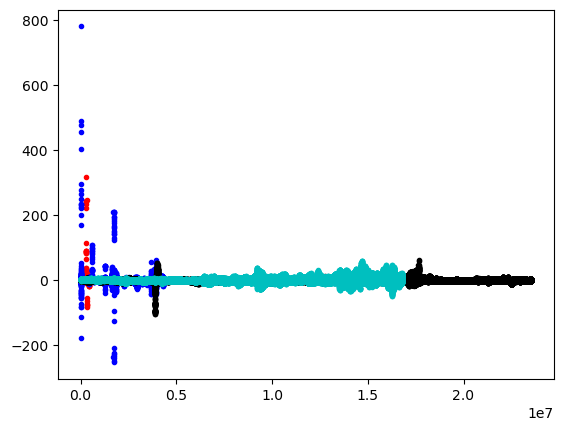

In [240]:
# Checks that sum of probabilities is = 1

print(np.sum(cts_du_glad*du3x))
print(np.sum(cts_du_laser*du3x))
print(np.sum(cts_du3_glad*du3x))
print(np.sum(cts_du3_laser*du3x))

plt.plot(du3_glad/np.std(du3_glad), '.r')
plt.plot(du3_laser/np.std(du3_laser), '.b')
plt.plot(du3_glad0/np.std(du3_glad0), '.k')
plt.plot(du3_laser0/np.std(du3_laser0), '.c')

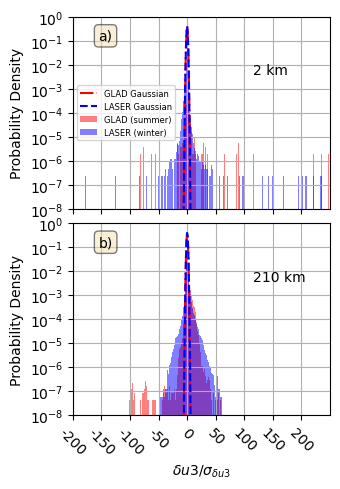

In [284]:
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as ticker

fig, ax = plt.subplots(2, 1, figsize=(3.5, 5), sharex=True)

du3_mbins = 0.5*(du3_bins[:-1] + du3_bins[1:])

# ------------------- Top panel: GLAD + LASER summer/winter -------------------
ax[0].bar(du3_mbins, cts_du3_glad, color='r', alpha=0.5, width=du3x, label='GLAD (summer)')
ax[0].bar(du3_mbins, cts_du3_laser, color='b', alpha=0.5, width=du3x, label='LASER (winter)')
ax[0].plot(du3_bins, glad_norm, '-.r', label='GLAD Gaussian')
ax[0].plot(du3_bins, laser_norm, '--b', label='LASER Gaussian')

ax[0].set_yscale('log')
ax[0].set_xlim(-230, 230)
ax[0].set_ylabel('Probability Density')
ax[0].text(0.1, 0.88, 'a)', transform=ax[0].transAxes, bbox=props)
ax[0].text(0.7, 0.7, "{} km".format(round(dist_all[io]*1e-3)), transform=ax[0].transAxes)
ax[0].yaxis.set_major_locator(ticker.LogLocator(base=10, numticks=15))
ax[0].set_xticks(np.arange(-200, 250, 50))
ax[0].set_ylim(1e-8, 1e0)
ax[0].legend(fontsize=6, loc=6)
ax[0].grid()

# ------------------- Bottom panel: GLAD + LASER summer/winter (alt bins) -------------------
ax[1].bar(du3_mbins, cts_du3_glad0, color='r', alpha=0.5, width=du3x, label='GLAD (summer)')
ax[1].bar(du3_mbins, cts_du3_laser0, color='b', alpha=0.5, width=du3x, label='LASER (winter)')
ax[1].plot(du3_bins, glad0_norm, '-.r', label='GLAD Gaussian fit')
ax[1].plot(du3_bins, laser0_norm, '--b', label='LASER Gaussian fit')

ax[1].set_yscale('log')
ax[1].set_xlim(-200, 250)
ax[1].set_xlabel('$\\delta u3/\\sigma_{\\delta u3}$')
ax[1].set_ylabel('Probability Density')
ax[1].text(0.1, 0.88, 'b)', transform=ax[1].transAxes, bbox=props)
ax[1].text(0.7, 0.7, "{} km".format(round(distkm[ip])), transform=ax[1].transAxes)
ax[1].yaxis.set_major_locator(ticker.LogLocator(base=10, numticks=15))
ax[1].set_ylim(1e-8, 1e0)
ax[1].grid()
ax[1].set_xticklabels(ax[1].get_xticks(), rotation=-45)

fig.tight_layout(h_pad=-0.3)
fig.savefig('./FiguresMethodsPaper/fig_du3_PDF_drifter_N.png', bbox_inches = 'tight', format='png', dpi=500)

In [282]:
# Percentiles
print('GLAD percentiles %4.0f km: 5th: %3.3f 95th: %3.5f' % (round(distkm[ip]), np.percentile(du3_glad/np.std(du3_glad), 5), np.percentile(du3_glad/np.std(du3_glad), 95)))
print('LASER percentiles %4.0f km: 5th: %3.3f 95th: %3.5f' % (round(distkm[ip]), np.percentile(du3_laser/np.std(du3_laser), 5), np.percentile(du3_laser/np.std(du3_laser), 95)))
print('GLAD percentiles %4.0f km: 5th: %3.3f 95th: %3.5f' % (round(distkm[io]), np.percentile(du3_glad0/np.std(du3_glad0), 5), np.percentile(du3_glad0/np.std(du3_glad0), 95)))
print('LASER percentiles %4.0f km: 5th: %3.3f 95th: %3.5f' % (round(distkm[io]), np.percentile(du3_laser0/np.std(du3_laser0), 5), np.percentile(du3_laser0/np.std(du3_laser0), 95)))

GLAD percentiles  210 km: 5th: -0.043 95th: 0.02887
LASER percentiles  210 km: 5th: -0.418 95th: 0.30025
GLAD percentiles    2 km: 5th: -0.554 95th: 1.06626
LASER percentiles    2 km: 5th: -0.468 95th: 1.14024


# KE transfers (fluxes)

The third-order structure function $D3(r)$ is connected to the azimuthally averaged, cross-scale kinetic energy (KE) transfer $F(k)$ through a Hankel transform:
%
\begin{equation}
    D3(r) = -4r \int_0^\infty \frac{1}{k} F(k) J_2(kr)\,dk, 
\end{equation}
%
where $J_2$ is the second-order Bessel function \citep{xie2019third}. Positive values $F(k) > 0$ indicate a \emph{forward} cascade (KE transfer toward smaller scales), whereas $F(k) < 0$ indicates an \emph{inverse} cascade (transfer toward larger scales).  

Following \citet{balwada2022direct}, the spectral flux can be discretized using a step-function basis as  
%
\begin{equation}
    F(k) = -\epsilon_u + \sum_{j=1}^{N_k} \xi_j\, H(k-k_j)\, d k_j, 
\end{equation}
%
where 
$\epsilon_u$ represents the \emph{upscale} energy injection, 
$\epsilon_d = \sum_{j=1}^{N_k} \xi_j\,  dk_j - \epsilon_u> 0$ denotes the \emph{downscale} transfer, 
$\epsilon_u + \epsilon_d$ is the total KE injection, 
$H$ is the Heaviside function, and 
$N_k$ is the number of discrete wavenumbers $k_j$.  

Substituting (\ref{eq:ke_flux2}) into (\ref{eq:ke_flux1}) yields  
%
\begin{equation}
    D3(r) = 2 \epsilon_u\, r - \sum_{j=1}^{N_k} 4 \frac{\xi_j}{k_j} J_1(k_j r)\, d k_j,
\end{equation}
%
where $J_1$ is the first-order Bessel function.  

Equation~(\ref{eq:ke_flux3}) forms the basis for a \emph{discrete linear inverse problem}: given an estimate of $D3(r)$, the goal is to recover $\epsilon_u$ and the discrete transfer amplitudes $\xi_j$ at the selected wavenumbers $k_j$.


<!-- ### NON-NEGATIVE LEAST SQUARES

To estimate confidence intervals, we use bootstrapping to estimate 1000 bootstrapped $D3(r)$ samples and invert them using NNLS. The uncertainty in $F(k)$ and $\epsilon_j$ is calculated as the standard deviation of the 1000 inverted quantities. -->

# Moving block bootstrap

### Using ordinary bootstrapping yields unrealisticly small errors in the third-order structure function, thus small errors in the cross-scale transfers $F(k)$ and injection rates $\epsilon$. This is because data presents a temporal correlation such that each data point is not independent from others.

## An alternative methodology for estimating standard errros is moving block bootstrapping:

##### For moving-block bootstrapping, we construct a pseudo-time series of $\delta u3(r,t)$ for each $r$ bin from several concatenated time series of different pairs of drifters. The concatenated records inherently have some autocorrelation because of the spatio-temporal proximity between pairs. Then we divided the concatenated $\delta u3(r,t)$ data for each $r$ bin into overlapping blocks of data of size $L(r)/N(r)$, where $L(r)$ is the length of the concatenated data per $r$ bin and $N(r)$ is the number degrees of freedom. Here, $N(r)$ is roughly estimated by dividing the total duration of each drifter experiment by the decorrelation timescale at each $r$, which was calculated with the help of $D2(r)$. Next, we sample $b$ blocks with replacement at each $r$ and concatenate them to construct a pseudo-time series of $\delta u3(r,t)$ of length $L(r)$. The mean of this pair-sample set gives a bootstrap estimate of $D3(r)$ ($D3_b(r)$). We repeat this step 2000 times to ensure that the bootstrap estimates $D3(r)_b$ are Gaussian-distributed per central limit theorem \citep{stroock2010probability}.


We employ arch 6.3.0 by Sheppard et al (2021) to perform the moving block bootstrapping. The software is available in Zenodo (https://doi.org/10.5281/zenodo.593254) and in (https://arch.readthedocs.io/en/latest/index.html).

## Some tests

In [16]:
from arch.bootstrap import StationaryBootstrap
from arch.bootstrap import MovingBlockBootstrap

seed = np.random.default_rng()

In [17]:
du3g = laser_dul[10]**3 + laser_dut[10]**2*laser_dul[10]

In [18]:
Nblk = round(dof_laser[10])
blksiz = round(len(du3g)/Nblk)

In [310]:
# Stationary Block Bootstrapping
bs = StationaryBootstrap(blksiz, du3g, seed=seed)
results = bs.apply(np.mean, 1000)

# Moving Block Bootstrapping
bs1 = MovingBlockBootstrap(blksiz, du3g, seed=seed)
results1 = bs1.apply(np.mean, 1000)

# Stationary Block Bootstrapping
bs2 = StationaryBootstrap(1, du3g, seed=seed)
results2 = bs2.apply(np.mean, 1000)

[-0.28415479]


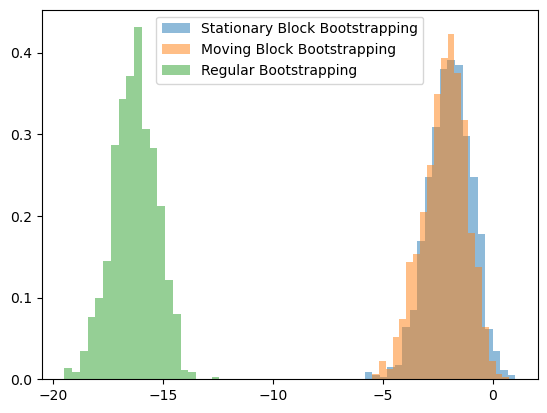

In [314]:
print(skew(results[:, -1:]/np.std(results[:, -1:])))


plt.hist(results[:, -1:]/np.std(results[:, -1:]), bins=20, density=True, alpha=0.5, label='Stationary Block Bootstrapping')
plt.hist(results1[:, -1:]/np.std(results1[:, -1:]), bins=20, density=True, alpha=0.5, label='Moving Block Bootstrapping')
plt.hist(results2[:, -1:]/np.std(results2[:, -1:]), bins=20, density=True, alpha=0.5, label='Regular Bootstrapping')
plt.legend()

In [21]:
# Calculates mean, std err, skewness and (excess of) kurtosis
mean_rbstrp = np.mean(results2[:, -1:])
std_rbstrp = np.std(results2[:, -1:])
mean_bbstrp = np.mean(results[:, -1:])
std_bbstrp = np.std(results[:, -1:])
mean_movbbstrp = np.mean(results1[:, -1:])
std_movbbstrp = np.std(results1[:, -1:])

print('### Data statistics ###')
print('Mean $\\pm$ std. err = %0.5f $\\pm$ %0.5f' % (np.nanmean(du3g), np.nanstd(du3g)))
print('Skewness = %0.2f' % skew(du3g))
print('Kurtosis = %0.2f' % kurtosis(du3g, fisher=True))
print('\n')
print('### Ordinary Bootstrap ###')
print('Mean $\\pm$ std. err = %0.5f $\\pm$ %0.5f' % (mean_rbstrp, std_rbstrp))
print('Skewness = %0.2f' % skew(results2))
print('Kurtosis = %0.2f' % kurtosis(results2, fisher=True))
print('\n')
print('### Stationary Block Bootstrap ###')
print('Mean $\\pm$ std. err = %0.5f $\\pm$ %0.5f' % (mean_bbstrp, std_bbstrp))
print('Skewness = %0.2f' % skew(results[:, -1]))
print('Kurtosis = %0.2f' % kurtosis(results[:, -1], fisher=True))
print('\n')
print('### Moving Block Bootstrap ###')
print('Mean $\\pm$ std. err = %0.5f $\\pm$ %0.5f' % (mean_movbbstrp, std_movbbstrp))
print('Skewness = %0.2f' % skew(results1[:, -1]))
print('Kurtosis = %0.2f' % kurtosis(results1[:, -1], fisher=True))


### Data statistics ###
Mean $\pm$ std. err = -0.00068 $\pm$ 0.09800
Skewness = -32.57
Kurtosis = 463191.41


### Ordinary Bootstrap ###
Mean $\pm$ std. err = -0.00067 $\pm$ 0.00004
Skewness = 0.00
Kurtosis = -0.03


### Stationary Block Bootstrap ###
Mean $\pm$ std. err = -0.00069 $\pm$ 0.00035
Skewness = -0.32
Kurtosis = 0.04


### Moving Block Bootstrap ###
Mean $\pm$ std. err = -0.00068 $\pm$ 0.00030
Skewness = -0.23
Kurtosis = -0.16


/tmp/ipykernel_1581509/815226284.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Skewness = %0.2f' % skew(results2))
/tmp/ipykernel_1581509/815226284.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Kurtosis = %0.2f' % kurtosis(results2, fisher=True))


## Estimating std errors in $D3(r)$ using moving block bootstrapping

In [22]:
from tqdm_joblib import tqdm_joblib  # pip install tqdm_joblib

def movingblock_bootstrap_parallel(ii, nrep, glad_dul, glad_dut, laser_dul, laser_dut, dof_glad, dof_laser, seed):
    du3g = glad_dul[ii]**3 + glad_dut[ii]**2 * glad_dul[ii]
    du3l = laser_dul[ii]**3 + laser_dut[ii]**2 * laser_dul[ii]

    Nblk_g = round(dof_glad[ii])
    blksiz_g = max(1, round(len(du3g) / Nblk_g))
    Nblk_l = round(dof_laser[ii])
    blksiz_l = max(1, round(len(du3l) / Nblk_l))

    bsg = MovingBlockBootstrap(blksiz_g, du3g, seed=seed)
    blstrap_glad = bsg.apply(np.mean, nrep)[:, 0]

    bsl = MovingBlockBootstrap(blksiz_l, du3l, seed=seed)
    blstrap_laser = bsl.apply(np.mean, nrep)[:, 0]

    return blstrap_glad, blstrap_laser

def run_moving_block_bootstrap_parallel(nrep, njobs, dist_all, glad_dul, glad_dut, laser_dul, laser_dut, dof_glad, dof_laser, seed=None):
    mvblstrap_glad = np.zeros((nrep, len(dist_all)))
    mvblstrap_laser = np.zeros_like(mvblstrap_glad)

    with tqdm_joblib(tqdm(desc="Bootstrap progress", total=len(dist_all))) as progress_bar:
        results = Parallel(n_jobs=njobs)(
            delayed(movingblock_bootstrap_parallel)(
                ii, nrep, glad_dul, glad_dut, laser_dul, laser_dut, dof_glad, dof_laser, seed
            )
            for ii in range(len(dist_all))
        )

    for ii, (mvglad, mvlaser) in enumerate(results):
        mvblstrap_glad[:, ii] = mvglad
        mvblstrap_laser[:, ii] = mvlaser

    return mvblstrap_glad, mvblstrap_laser

/home/mog002/miniconda3/envs/pygmt/lib/python3.11/site-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [23]:
mvblstrap_glad, mvblstrap_laser = run_moving_block_bootstrap_parallel(
    nrep=2000,
    njobs=10,
    dist_all=dist_all,
    glad_dul=glad_dul,
    glad_dut=glad_dut,
    laser_dul=laser_dul,
    laser_dut=laser_dut,
    dof_glad=dof_glad,
    dof_laser=dof_laser,
    seed=None  # Optional
)

Bootstrap progress:   0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

In [252]:
# Calculates Gaussian curve for bootstrapped data
iu = 9
il = 20

D3bx = 0.55
D3b_bins = np.arange(-12, 12, D3bx)

glad_norm0 = norm.pdf(D3b_bins, np.mean(mvblstrap_glad[:, iu])/np.std(mvblstrap_glad[:, iu]), 1)
glad_norm1 = norm.pdf(D3b_bins, np.mean(mvblstrap_glad[:, il])/np.std(mvblstrap_glad[:, il]), 1)
laser_norm0 = norm.pdf(D3b_bins, np.mean(mvblstrap_laser[:, iu])/np.std(mvblstrap_laser[:, iu]), 1)
laser_norm1 = norm.pdf(D3b_bins, np.mean(mvblstrap_laser[:, il])/np.std(mvblstrap_laser[:, il]), 1)

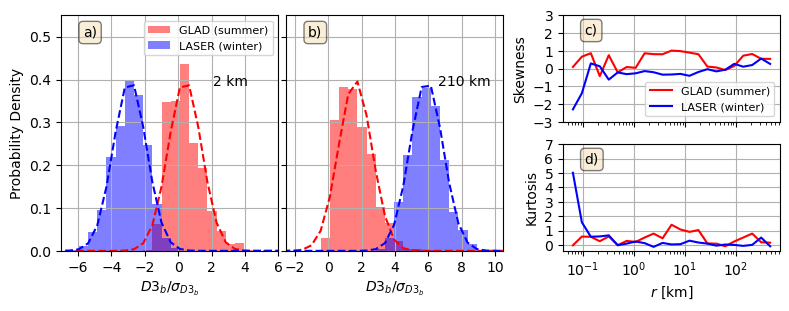

In [254]:
from matplotlib import gridspec
gs = gridspec.GridSpec(3, 4, width_ratios=[1, 1, 0.2, 1])


fiu = plt.figure(figsize=(8, 4))

plt.subplot(gs[0:2, 0])
plt.hist(mvblstrap_glad[:, iu]/np.std(mvblstrap_glad[:, iu]), 
         bins=D3b_bins, alpha=0.5, density=True, color='red', label='GLAD (summer)')
plt.plot(D3b_bins, glad_norm0, '--r')
plt.hist(mvblstrap_laser[:, iu]/np.std(mvblstrap_laser[:, iu]), 
         bins=D3b_bins, alpha=0.5, density=True, color='blue', label='LASER (winter)')
plt.plot(D3b_bins, laser_norm0, '--b')
plt.ylim(0, 0.55)
plt.gca().set_xticks(np.arange(-12, 14, 2))
plt.xlim(-7, 6)
plt.ylabel('Probability Density')
plt.xlabel('$D3_b/\\sigma_{D3_b}$')
plt.text(0.1, 0.91, 'a)', transform=plt.gca().transAxes, bbox=props)
plt.text(0.7, 0.7, "{} km".format(round(dist_all[iu]*1e-3)), transform=plt.gca().transAxes)
plt.legend(fontsize=8, loc=1)
plt.grid()

plt.subplot(gs[0:2, 1])
plt.hist(mvblstrap_glad[:, il]/np.std(mvblstrap_glad[:, il]), 
         bins=D3b_bins, alpha=0.5, density=True, color='red')
plt.plot(D3b_bins, glad_norm1, '--r')
plt.hist(mvblstrap_laser[:, il]/np.std(mvblstrap_laser[:, il]), 
         bins=D3b_bins, alpha=0.5, density=True, color='blue')
plt.plot(D3b_bins, laser_norm1, '--b')
plt.gca().set_yticklabels([])
plt.gca().set_xticks(np.arange(-2, 12, 2))
plt.ylim(0, 0.55)
plt.xlim(-2.5, 10.5)
plt.xlabel('$D3_b/\\sigma_{D3_b}$')
plt.text(0.1, 0.91, 'b)', transform=plt.gca().transAxes, bbox=props)
plt.text(0.7, 0.7, "{} km".format(round(distkm[il])), transform=plt.gca().transAxes)
plt.grid()


plt.subplot(gs[0:2, 2])
plt.gca().set_visible(False)


plt.subplot(gs[0:1, 3])
plt.semilogx(dist_all*1e-3, skew(mvblstrap_glad, axis=0), '-r', label='GLAD (summer)')
plt.semilogx(dist_all*1e-3, skew(mvblstrap_laser, axis=0), '-b', label='LASER (winter)')
plt.ylim(-3, 3)
plt.gca().set_xticklabels([])
plt.gca().set_xticks([0.1, 1, 10, 100])
plt.gca().set_yticks(np.arange(-3, 4, 1))
plt.ylabel('Skewness')
plt.text(0.1, 0.82, 'c)', transform=plt.gca().transAxes, bbox=props)
plt.legend(fontsize=8, loc=4)
plt.grid()


plt.subplot(gs[1:2, 3])
plt.semilogx(dist_all*1e-3, kurtosis(mvblstrap_glad, fisher=True, axis=0), '-r')
plt.semilogx(dist_all*1e-3, kurtosis(mvblstrap_laser, fisher=True, axis=0), '-b')
plt.ylim(-0.4, 6.8)
plt.gca().set_xticks([0.1, 1, 10, 100])
plt.gca().set_yticks(np.arange(0, 8, 1))
plt.grid()
plt.xlabel('$r$ [km]')
plt.ylabel('Kurtosis')
plt.text(0.1, 0.82, 'd)', transform=plt.gca().transAxes, bbox=props)


plt.tight_layout(w_pad=-3, h_pad=-2)
fiu.savefig('./FiguresMethodsPaper/fig_D3b_kurt_movBstr_N.png', bbox_inches = 'tight', format='png', dpi=500)

## Non-negative least-squares fitting of the moving block bootstrapped samples

NNLS method inherently cannot capture negative KE injection rates (indicative of KE transfer convergence). As a result, the derived KE transfers are strictly increasing with wavenumber — an assumption that may not hold universally, such as during the conversion of KE to potential energy.

Both $k$ and $r$ are equally spaced in log spaced following Balwada et al. 2022

In [56]:
# Non-negative least-squares on each bootstrapped mean
from scipy.optimize import nnls

# kbins_nn = np.logspace(np.log10(1/max(dist_all)), np.log10(1/min(dist_all)), len(dist_all)-1) ;
dk_nn = 1/max(dist_all)
kbins_nn = np.arange(0, 1/(2*(dist_all[1]-dist_all[0])), 1/max(dist_all))

dk_nn = np.diff(kbins_nn)[1:]
kbins_nn = 0.5*(kbins_nn[0:-1] + kbins_nn[1:])[1:]

rmat, kmat = np.meshgrid(dist_all, np.arange(0, len(kbins_nn)+1))

# Define model matrix
Ann = defA(dist_all, kbins_nn, dk_nn)/rmat.T

nrep = mvblstrap_glad.shape[0]

eps_glad_nnls_mvbbstr = np.zeros((nrep, len(kbins_nn)+1))
eps_laser_nnls_mvbbstr = eps_glad_nnls_mvbbstr*0.
Fk_glad_nnls_mvbbstr = np.zeros((nrep, len(kbins_nn)))
Fk_laser_nnls_mvbbstr = Fk_glad_nnls_mvbbstr*0.
V3_glad_nnls_mvbbstr = np.zeros((nrep, len(dist_all)))
V3_laser_nnls_mvbbstr = V3_glad_nnls_mvbbstr*0.


# for ii in tqdm(range(nrep)):
#     # Non-negative LS
#     eps_glad_nnls_mvbbstr[ii, :] = nnls(Ann, mvblstrap_glad[ii, :]/dist_all)[0]
#     eps_laser_nnls_mvbbstr[ii, :] = nnls(Ann, mvblstrap_laser[ii, :]/dist_all)[0]
    
#     V3_glad_nnls_mvbbstr[ii, :] = np.dot(Ann, eps_glad_nnls_mvbbstr[ii, :]) # reconstructed V3
#     V3_laser_nnls_mvbbstr[ii, :] = np.dot(Ann, eps_laser_nnls_mvbbstr[ii, :]) # reconstructed V3
    
#     # Calculate energy cascade
#     Fk_glad_nnls_mvbbstr[ii, :] = calcFk(eps_glad_nnls_mvbbstr[ii, :], kbins_nn, dk_nn)
#     Fk_laser_nnls_mvbbstr[ii, :] = calcFk(eps_laser_nnls_mvbbstr[ii, :], kbins_nn, dk_nn)
    
# eps_err_glad_nnls_mvbbstr = np.std(eps_glad_nnls_mvbbstr, axis=0) #errors in eps
# eps_err_laser_nnls_mvbbstr = np.std(eps_glad_nnls_mvbbstr, axis=0) #errors in eps
# Fk_err_glad_nnls_mvbbstr = np.std(Fk_glad_nnls_mvbbstr, axis=0)# errors in F(k)
# Fk_err_laser_nnls_mvbbstr = np.std(Fk_laser_nnls_mvbbstr, axis=0)# errors in F(k)

# Parallel loop with simple progress bar
with tqdm(total=nrep, desc="NNLS Bootstrap") as pbar:
    results = Parallel(n_jobs=10, backend="loky")(
        delayed(lambda ii: (
            nnls(Ann, mvblstrap_glad[ii, :]/dist_all)[0],
            nnls(Ann, mvblstrap_laser[ii, :]/dist_all)[0],
            ii
        ))(ii) for ii in range(nrep)
    )
    pbar.update(nrep)  # update once when done

# Unpack results and finish computations
for eps_g, eps_l, ii in results:
    eps_glad_nnls_mvbbstr[ii, :] = eps_g
    eps_laser_nnls_mvbbstr[ii, :] = eps_l
    V3_glad_nnls_mvbbstr[ii, :] = np.dot(Ann, eps_g)
    V3_laser_nnls_mvbbstr[ii, :] = np.dot(Ann, eps_l)
    Fk_glad_nnls_mvbbstr[ii, :] = calcFk(eps_g, kbins_nn, dk_nn)
    Fk_laser_nnls_mvbbstr[ii, :] = calcFk(eps_l, kbins_nn, dk_nn)

# Errors after parallel loop
eps_err_glad_nnls_mvbbstr = np.std(eps_glad_nnls_mvbbstr, axis=0)
eps_err_laser_nnls_mvbbstr = np.std(eps_laser_nnls_mvbbstr, axis=0)
Fk_err_glad_nnls_mvbbstr = np.std(Fk_glad_nnls_mvbbstr, axis=0)
Fk_err_laser_nnls_mvbbstr = np.std(Fk_laser_nnls_mvbbstr, axis=0)

NNLS Bootstrap:   0%|          | 0/2000 [00:00<?, ?it/s]

### REGULARIZED LEAST-SQUARES

Regularized least-squares requires that $\mathbf{x}$ and $\mathbf{e}$ have Gaussian distributions. The most probable model solutions are given by 
%
\begin{equation}
    \widetilde{\mathbf{x}} = \big(\mathbf{H}^\text{T} \mathbf{W}^{-1} \mathbf{H} + \mathbf{P}^{-1}\big)^{-1} \mathbf{H}^\text{T} \mathbf{W}^{-1} \mathbf{y}, \label{eq13} \\
\end{equation}
%
where $\widetilde{\mathbf{x}}$ is the column vector of size $M \times 1$ (where $M=N_k+1$) representing the fitted parameters ($\epsilon_u$ and $\epsilon_j$s), $\mathbf{y}$ is the vector of data to fit (i.e., $D3(r)$) of size $N_r$ (number of discrete $r$ bins), $\mathbf{e}$ is the residual, and $\mathbf{H}$ is the model matrix of size $N_r \times M$, $\mathbf{W}=\langle\mathbf{e} \mathbf{e}^\text{T}\rangle$ is the data covariance matrix representing the prior data uncertainty and is of size $N_r\times N_r$; $\mathbf{P}=\langle\mathbf{x}\mathbf{x}^\text{T}\rangle$ is the covariance matrix representing the prior uncertainty of the fitted parameters and is $M \times M$ \citep{kacheleinetal2022, wunsch1996}.

##### For $\mathbf{W}$ we use the squared of the prior uncertainty in $D3(r)$ calculated as the standard error of the bootstrapped samples $D3_b(r)$

In [255]:
#### Using log-spaced r but linearly-spaced k
# Mean and std error of mvb bootstrapped samples
glad_D3b_mean = np.mean(mvblstrap_glad, axis=0)
glad_D3b_std = np.std(mvblstrap_glad, axis=0)

laser_D3b_mean = np.mean(mvblstrap_laser, axis=0)
laser_D3b_std = np.std(mvblstrap_laser, axis=0)

# Define weight matrix
dk_mvb_logk = 1/max(dist_all)
kbins_mvb_logk = np.arange(0, 1/(2*(dist_all[1]-dist_all[0])), 1/max(dist_all))
# kbins_mvb_logk = np.linspace(0, (1/(2*(dist_all[2]-dist_all[1]))), 1000)
dk_mvb_logk = np.diff(kbins_mvb_logk)[1:]
kbins_mvb_logk = 0.5 * (kbins_mvb_logk[:-1] + kbins_mvb_logk[1:])[1:]
kbins_mvb_logk[0] = kbins_nn[0]

# Prior uncertainty D3(r)
W_glad_mvb_logk = np.diag(glad_D3b_std**2)#[indi:indf])
W_laser_mvb_logk = np.diag(laser_D3b_std**2)#[indi:indf])

# Prior uncertainty \epsilon_u and \epsilon_j
fac = 1e-05
fac_epsj_mvb = 0.3e-4

# GLAD
P_glad_mvb_logk = np.concatenate(([fac], np.ones((len(kbins_mvb_logk),))*fac_epsj_mvb), axis=0)
P_glad_mvb_logk = np.diag(P_glad_mvb_logk)

# LASER
P_laser_mvb_logk = np.concatenate(([fac], np.ones((len(kbins_mvb_logk),))*fac_epsj_mvb*0.12), axis=0)
P_laser_mvb_logk = np.diag(P_laser_mvb_logk)

# Defines H
Amvb_logk = defA(dist_all, kbins_mvb_logk, dk_mvb_logk*np.ones((len(kbins_mvb_logk))))
print(Amvb_logk.shape)

# Least squares
eps_glad_rls_mvb_logk, V3_glad_rls_mvb_logk, res_glad_rls_mvb_logk, cxx_glad_rls_mvb_logk = RLS(glad_D3b_mean, W_glad_mvb_logk, P_glad_mvb_logk, Amvb_logk)    
eps_laser_rls_mvb_logk, V3_laser_rls_mvb_logk, res_laser_rls_mvb_logk, cxx_laser_rls_mvb_logk = RLS(laser_D3b_mean, W_laser_mvb_logk, P_laser_mvb_logk, Amvb_logk)

# Injection rates errors
eps_err_glad_rls_mvb_logk = np.sqrt(np.diag(cxx_glad_rls_mvb_logk))
eps_err_laser_rls_mvb_logk = np.sqrt(np.diag(cxx_laser_rls_mvb_logk))

# Cross-scale flux
fk_glad_rls_mvb_logk = calcFk(eps_glad_rls_mvb_logk, kbins_mvb_logk, dk_mvb_logk*np.ones((len(kbins_mvb_logk))))
fk_laser_rls_mvb_logk = calcFk(eps_laser_rls_mvb_logk, kbins_mvb_logk, dk_mvb_logk*np.ones((len(kbins_mvb_logk))))

# Energy flux errors
Herr_mvb_logk = defH(kbins_mvb_logk, dk_mvb_logk*np.ones((len(kbins_mvb_logk))))
fk_err_glad_rls_mvb_logk = np.sqrt(np.diag(errorsFlux(cxx_glad_rls_mvb_logk, Herr_mvb_logk)))
fk_err_laser_rls_mvb_logk = np.sqrt(np.diag(errorsFlux(cxx_laser_rls_mvb_logk, Herr_mvb_logk)))

(23, 7481)


In [256]:
# eigval_cxx_glad_rls_mvb_logk, eigvec_cxx_glad_rls_mvb_logk = np.linalg.eig(cxx_glad_rls_mvb_logk)
# eigval_cxx_laser_rls_mvb_logk, eigvec_cxx_laser_rls_mvb_logk = np.linalg.eig(cxx_laser_rls_mvb_logk)

In [257]:
# --- Add top axis for panels c) and e) with [km] next to each ticklabel ---
def add_top_axis(ax, k_ticks=np.array([1/1000.0, 1/100.0, 1/10.0, 1.0]), unit='km'):
    ax_top = ax.twiny()
    ax_top.set_xscale('log')
    ax_top.set_xlim(ax.get_xlim())
    ax_top.xaxis.set_label_position('top')
    ax_top.xaxis.tick_top()

    # Tick locations in k-space
    kmin, kmax = ax.get_xlim()
    lo, hi = min(kmin, kmax), max(kmin, kmax)
    k_ticks = k_ticks[(k_ticks >= lo) & (k_ticks <= hi)]
    ax_top.set_xticks(k_ticks)

    # Tick labels with unit next to the value
    scale_labels = []
    for t in k_ticks:
        val = 1.0 / t
        if abs(val - round(val)) < 1e-6:  # if nearly integer
            scale_labels.append(f"{int(round(val))} {unit}")
        else:
            scale_labels.append(f"{val:.2f} {unit}")  # show decimals if needed

    ax_top.set_xticklabels(scale_labels)
    return ax_top

In [258]:
# Errors \xi
errl_eps_glad_nnls_mvbbstr = np.mean(eps_glad_nnls_mvbbstr, axis=0) - eps_err_glad_nnls_mvbbstr
errl_eps_glad_nnls_mvbbstr[errl_eps_glad_nnls_mvbbstr<0] = 0
erru_eps_glad_nnls_mvbbstr = np.mean(eps_glad_nnls_mvbbstr, axis=0) + eps_err_glad_nnls_mvbbstr

errl_eps_laser_nnls_mvbbstr = np.mean(eps_laser_nnls_mvbbstr, axis=0) - eps_err_laser_nnls_mvbbstr
errl_eps_laser_nnls_mvbbstr[errl_eps_laser_nnls_mvbbstr<0] = 0
erru_eps_laser_nnls_mvbbstr = np.mean(eps_laser_nnls_mvbbstr, axis=0) + eps_err_laser_nnls_mvbbstr

/tmp/ipykernel_1581509/2222507749.py:279: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig12.tight_layout()


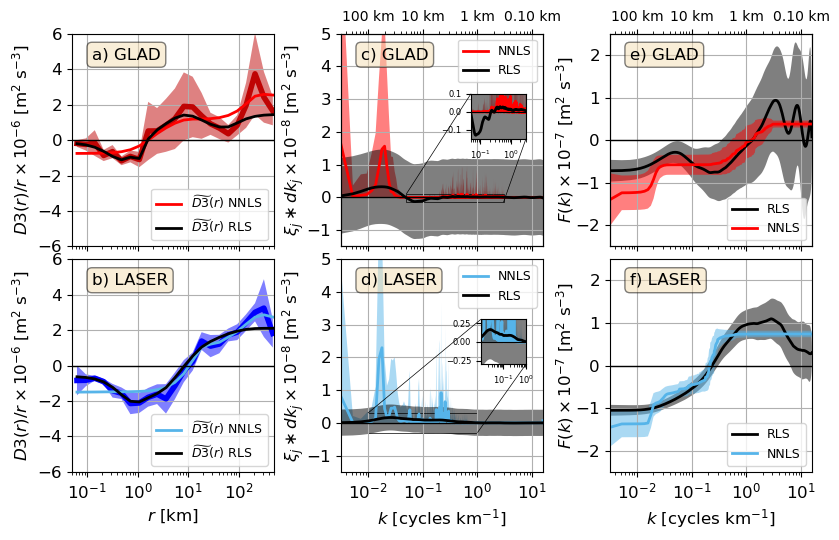

In [279]:
# Additional subplots
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

fig12, ax12 = plt.subplots(2, 3, figsize=(8.5, 5.5))

# ------------------- Panel a) GLAD D3 -------------------
ax12[0, 0].semilogx(dist_all*1e-3, glad_D3b_mean/dist_all*1e7, '#BF0404', linewidth=4)
ax12[0, 0].fill_between(
    dist_all*1e-3,
    (glad_D3b_mean - glad_D3b_std)/dist_all*1e7,
    (glad_D3b_mean + glad_D3b_std)/dist_all*1e7,
    alpha=0.5, color='#BF0404', edgecolor=None
)
ax12[0, 0].semilogx(
    distkm,
    np.nanmean(V3_glad_nnls_mvbbstr, axis=0)*1e7,
    '-', color='red', label='$\\widetilde{D3}(r)$ NNLS', linewidth=2
)
ax12[0, 0].semilogx(
    dist_all*1e-3,
    V3_glad_rls_mvb_logk/dist_all*1e7,
    '-', color='black', label='$\\widetilde{D3}(r)$ RLS', linewidth=2
)
ax12[0, 0].set_ylabel('$D3(r)/r \\times 10^{-6}$ [m$^2$ s$^{-3}$]', fontsize=12)
ax12[0, 0].set_xticklabels([])
ax12[0, 0].text(0.1, 0.88, 'a) GLAD', transform=ax12[0, 0].transAxes, bbox=props, fontsize=12)
ax12[0, 0].tick_params(labelsize=12)
ax12[0, 0].set_yticks(np.arange(-6, 8, 2))
ax12[0, 0].set_ylim(-6, 6)
ax12[0, 0].set_xlim(0.5e-1, 5e2)
ax12[0, 0].legend(fontsize=9, loc=4, ncol=1)
ax12[0, 0].grid()

# ------------------- Panel b) LASER D3 -------------------
ax12[1, 0].semilogx(dist_all*1e-3, laser_D3b_mean/dist_all*1e7, color='blue', linewidth=4)
ax12[1, 0].fill_between(
    dist_all*1e-3,
    (laser_D3b_mean - laser_D3b_std)/dist_all*1e7,
    (laser_D3b_mean + laser_D3b_std)/dist_all*1e7,
    alpha=0.5, color='blue', edgecolor=None
)
ax12[1, 0].semilogx(
    dist_all*1e-3,
    np.nanmean(V3_laser_nnls_mvbbstr, axis=0)*1e7,
    '-', color='#56B4E9', label='$\\widetilde{D3}(r)$ NNLS', linewidth=2
)
ax12[1, 0].semilogx(
    dist_all*1e-3,
    V3_laser_rls_mvb_logk/dist_all*1e7,
    '-', color='black', label='$\\widetilde{D3}(r)$ RLS', linewidth=2
)
ax12[1, 0].set_xlabel('$r$ [km]', fontsize=12)
ax12[1, 0].text(0.1, 0.88, 'b) LASER', transform=ax12[1, 0].transAxes, bbox=props, fontsize=12)
ax12[1, 0].set_ylabel('$D3(r)/r \\times 10^{-6}$ [m$^2$ s$^{-3}$]', fontsize=12)
ax12[1, 0].tick_params(labelsize=12)
ax12[1, 0].set_yticks(np.arange(-6, 8, 2))
ax12[1, 0].set_ylim(-6, 6)
ax12[1, 0].set_xlim(0.5e-1, 5e2)
ax12[1, 0].legend(fontsize=9, loc=4, ncol=1)
ax12[1, 0].grid()

# ------------------- Panel c) GLAD eps -------------------
ax12[0, 1].semilogx(
    kbins_nn*1e3,
    np.nanmean(eps_glad_nnls_mvbbstr[:, 1:], axis=0)*1e8*dk_nn,
    '-', color='red', label='NNLS', linewidth=2
)
ax12[0, 1].fill_between(
    kbins_nn*1e3,
    1e8*erru_eps_glad_nnls_mvbbstr[1:]*dk_nn,
    1e8*errl_eps_glad_nnls_mvbbstr[1:]*dk_nn,
    color='red', alpha=0.5, edgecolor=None
)
ax12[0, 1].semilogx(
    kbins_mvb_logk*1e3,
    eps_glad_rls_mvb_logk[1:]*1e8*dk_mvb_logk,
    '-', color='black', label='RLS', linewidth=2
)
ax12[0, 1].fill_between(
    kbins_mvb_logk*1e3,
    1e8*(eps_glad_rls_mvb_logk[1:] - eps_err_glad_rls_mvb_logk[1:])*dk_mvb_logk,
    1e8*(eps_glad_rls_mvb_logk[1:] + eps_err_glad_rls_mvb_logk[1:])*dk_mvb_logk,
    color='black', alpha=0.5, edgecolor=None
)
ax12[0, 1].set_ylabel('$\\xi_j \\ast dk_j\\times 10^{-8}$ [m$^2$ s$^{-3}$]', fontsize=12,labelpad=-0.3)
ax12[0, 1].set_xticklabels([])
ax12[0, 1].tick_params(labelsize=12)
ax12[0, 1].text(0.1, 0.88, 'c) GLAD', transform=ax12[0, 1].transAxes, bbox=props, fontsize=12)
ax12[0, 1].legend(fontsize=9, loc=1, ncol=1)
ax12[0, 1].set_yticks(np.arange(-2, 6))
ax12[0, 1].set_ylim(-1.5, 5)
ax12[0, 1].set_xlim(kbins_nn.min()*1e3, kbins_nn.max()*1e3)
ax12[0, 1].grid()

# Inset for c)
axinsc = inset_axes(ax12[0, 1], 0.55, 0.45, loc=1, 
                   bbox_to_anchor=(0.95, 0.75),  # upper right corner
                   bbox_transform=ax12[0, 1].transAxes)  # relative to ax[2]

axinsc.semilogx(
    kbins_nn*1e3,
    np.nanmean(eps_glad_nnls_mvbbstr[:, 1:], axis=0)*1e8*dk_nn,
    '-', color='red', label='NNLS', linewidth=2
)
axinsc.fill_between(
    kbins_nn*1e3,
    1e8*erru_eps_glad_nnls_mvbbstr[1:]*dk_nn,
    1e8*errl_eps_glad_nnls_mvbbstr[1:]*dk_nn,
    color='red', alpha=0.5, edgecolor=None
)
axinsc.semilogx(
    kbins_mvb_logk*1e3,
    eps_glad_rls_mvb_logk[1:]*1e8*dk_mvb_logk,
    '-', color='black', label='RLS', linewidth=2
)
axinsc.fill_between(
    kbins_mvb_logk*1e3,
    1e8*(eps_glad_rls_mvb_logk[1:] - eps_err_glad_rls_mvb_logk[1:])*dk_mvb_logk,
    1e8*(eps_glad_rls_mvb_logk[1:] + eps_err_glad_rls_mvb_logk[1:])*dk_mvb_logk,
    color='black', alpha=0.5, edgecolor=None
)
axinsc.axhline(0, color='black', linewidth=0.8, linestyle='-')

# Format inset ticks (small + cleaner)
axinsc.set_xticks([1e-1, 1e0])
# Zoom limits
axinsc.set_xlim(5e-2, 3)
axinsc.set_ylim(-0.15, 0.1)
axinsc.tick_params(axis='both', which='both', labelbottom=True, labelsize=6)


# Connect zoom region to main plot with dashed box + connectors
mark_inset(ax12[0, 1], axinsc, loc1=2, loc2=4, fc="none", ec="black", lw=0.5)

# ------------------- Panel d) LASER eps -------------------
ax12[1, 1].semilogx(
    kbins_nn*1e3,
    np.nanmean(eps_laser_nnls_mvbbstr[:, 1:], axis=0)*1e8*dk_nn,
    '-', color='#56B4E9', label='NNLS', linewidth=2
)
ax12[1, 1].fill_between(
    kbins_nn*1e3,
    1e8*erru_eps_laser_nnls_mvbbstr[1:]*dk_nn,
    1e8*errl_eps_laser_nnls_mvbbstr[1:]*dk_nn,
    color='#56B4E9', alpha=0.5, edgecolor=None
)
ax12[1, 1].semilogx(
    kbins_mvb_logk*1e3,
    eps_laser_rls_mvb_logk[1:]*1e8*dk_mvb_logk,
    '-', color='black', label='RLS', linewidth=2
)
ax12[1, 1].fill_between(
    kbins_mvb_logk*1e3,
    1e8*(eps_laser_rls_mvb_logk[1:] - eps_err_laser_rls_mvb_logk[1:])*dk_mvb_logk,
    1e8*(eps_laser_rls_mvb_logk[1:] + eps_err_laser_rls_mvb_logk[1:])*dk_mvb_logk,
    color='black', alpha=0.5, edgecolor=None
)


ax12[1, 1].set_xlabel('$k$ [cycles km$^{-1}$]', fontsize=12)
ax12[1, 1].set_ylabel('$\\xi_j \\ast dk_j\\times 10^{-8}$ [m$^2$ s$^{-3}$]', fontsize=12, labelpad=-0.3)
ax12[1, 1].tick_params(labelsize=12)
ax12[1, 1].set_yticks(np.arange(-2, 6))
ax12[1, 1].text(0.1, 0.88, 'd) LASER', transform=ax12[1, 1].transAxes, bbox=props, fontsize=12)
ax12[1, 1].legend(fontsize=9, loc=1, ncol=1)
ax12[1, 1].set_ylim(-1.5, 5)
ax12[1, 1].set_xlim(kbins_nn.min()*1e3, kbins_nn.max()*1e3)
ax12[1, 1].grid()

# Inset for d)
axinsd = inset_axes(ax12[1, 1], 0.45, 0.45, loc=1, 
                   bbox_to_anchor=(0.95, 0.75),  # upper right corner
                   bbox_transform=ax12[1, 1].transAxes)  # relative to ax[2]

axinsd.semilogx(
    kbins_nn*1e3,
    np.nanmean(eps_laser_nnls_mvbbstr[:, 1:], axis=0)*1e8*dk_nn,
    '-', color='#56B4E9', label='NNLS', linewidth=2
)
axinsd.fill_between(
    kbins_nn*1e3,
    1e8*erru_eps_laser_nnls_mvbbstr[1:]*dk_nn,
    1e8*errl_eps_laser_nnls_mvbbstr[1:]*dk_nn,
    color='#56B4E9', alpha=0.5, edgecolor=None
)
axinsd.semilogx(
    kbins_mvb_logk*1e3,
    eps_laser_rls_mvb_logk[1:]*1e8*dk_mvb_logk,
    '-', color='black', label='RLS', linewidth=2
)
axinsd.fill_between(
    kbins_mvb_logk*1e3,
    1e8*(eps_laser_rls_mvb_logk[1:] - eps_err_laser_rls_mvb_logk[1:])*dk_mvb_logk,
    1e8*(eps_laser_rls_mvb_logk[1:] + eps_err_laser_rls_mvb_logk[1:])*dk_mvb_logk,
    color='black', alpha=0.5, edgecolor=None
)
axinsd.axhline(0, color='black', linewidth=0.8, linestyle='-')

# Format inset ticks (small + cleaner)
axinsd.set_xticks([1e-1, 1e0])
# Zoom limits
axinsd.set_xlim(1e-2, 1)
axinsd.set_ylim(-0.3, 0.3)
axinsd.tick_params(axis='both', which='both', labelbottom=True, labelsize=6)


# Connect zoom region to main plot with dashed box + connectors
mark_inset(ax12[1, 1], axinsd, loc1=2, loc2=4, fc="none", ec="black", lw=0.5)



# ------------------- Panel e) GLAD F(k) -------------------
ax12[0, 2].semilogx(kbins_mvb_logk*1e3, fk_glad_rls_mvb_logk*1e7, '-', color='black', label='RLS', linewidth=2)
ax12[0, 2].fill_between(
    kbins_mvb_logk*1e3,
    1e7*(fk_glad_rls_mvb_logk + fk_err_glad_rls_mvb_logk),
    1e7*(fk_glad_rls_mvb_logk - fk_err_glad_rls_mvb_logk),
    color='black', alpha=0.5, edgecolor=None
)
ax12[0, 2].semilogx(
    kbins_nn*1e3,
    1e7*np.nanmean(Fk_glad_nnls_mvbbstr, axis=0),
    '-', color='red', label='NNLS', linewidth=2
)
ax12[0, 2].fill_between(
    kbins_nn*1e3,
    1e7*(np.nanmean(Fk_glad_nnls_mvbbstr, axis=0) + Fk_err_glad_nnls_mvbbstr),
    1e7*(np.nanmean(Fk_glad_nnls_mvbbstr, axis=0) - Fk_err_glad_nnls_mvbbstr),
    color='red', alpha=0.5, edgecolor=None
)
ax12[0, 2].set_ylabel('$F(k) \\times 10^{-7}$ [m$^2$ s$^{-3}$]', fontsize=12, labelpad=-0.3)
ax12[0, 2].text(0.1, 0.88, 'e) GLAD', transform=ax12[0, 2].transAxes, bbox=props, fontsize=12)
ax12[0, 2].set_xticklabels([])
ax12[0, 2].tick_params(labelsize=12)
ax12[0, 2].set_xlim(kbins_nn.min()*1e3, kbins_nn.max()*1e3)
ax12[0, 2].legend(fontsize=9, loc=4, ncol=1)
ax12[0, 2].set_ylim(-2.5, 2.5)
ax12[0, 2].grid()

# ------------------- Panel f) LASER F(k) -------------------
ax12[1, 2].semilogx(kbins_mvb_logk*1e3, fk_laser_rls_mvb_logk*1e7, '-', color='black', label='RLS', linewidth=2)
ax12[1, 2].fill_between(
    kbins_mvb_logk*1e3,
    1e7*(fk_laser_rls_mvb_logk + fk_err_laser_rls_mvb_logk),
    1e7*(fk_laser_rls_mvb_logk - fk_err_laser_rls_mvb_logk),
    color='black', alpha=0.5, edgecolor=None
)
ax12[1, 2].semilogx(
    kbins_nn*1e3,
    1e7*np.nanmean(Fk_laser_nnls_mvbbstr, axis=0),
    '-', color='#56B4E9', label='NNLS', linewidth=2
)
ax12[1, 2].fill_between(
    kbins_nn*1e3,
    1e7*(np.nanmean(Fk_laser_nnls_mvbbstr, axis=0) + Fk_err_laser_nnls_mvbbstr),
    1e7*(np.nanmean(Fk_laser_nnls_mvbbstr, axis=0) - Fk_err_laser_nnls_mvbbstr),
    color='#56B4E9', alpha=0.5, edgecolor=None
)
ax12[1, 2].set_ylabel('$F(k) \\times 10^{-7}$ [m$^2$ s$^{-3}$]', fontsize=12, labelpad=-0.3)
ax12[1, 2].set_xlabel('$k$ [cycles km$^{-1}$]', fontsize=12)
ax12[1, 2].text(0.1, 0.88, 'f) LASER', transform=ax12[1, 2].transAxes, bbox=props, fontsize=12)
ax12[1, 2].tick_params(labelsize=12)
ax12[1, 2].set_xlim(kbins_mvb_logk.min()*1e3, kbins_mvb_logk.max()*1e3)
ax12[1, 2].legend(fontsize=9, loc=4, ncol=1)
ax12[1, 2].set_ylim(-2.5, 2.5)
ax12[1, 2].grid()

# ------------------- Top axes -------------------
k_ticks = np.array([1/1000.0, 1/100.0, 1/10.0, 1.0, 10.0])
ax_top_c = add_top_axis(ax12[0,1], k_ticks, unit='km')
ax_top_e = add_top_axis(ax12[0,2], k_ticks, unit='km')

# ------------------- Zero line across all subplots -------------------
for i in range(2):
    for j in range(3):
        ax12[i, j].axhline(0, color='k', linestyle='-', linewidth=1)

# ------------------- Layout -------------------
fig12.tight_layout()
fig12.subplots_adjust(hspace=0.06, wspace=0.33)
fig12.savefig('./FiguresMethodsPaper/fig_drifter_D3_xi_Fk.png', bbox_inches = 'tight', format='png', dpi=500)

/tmp/ipykernel_1581509/4238969370.py:161: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig12.tight_layout(h_pad=-0.9)


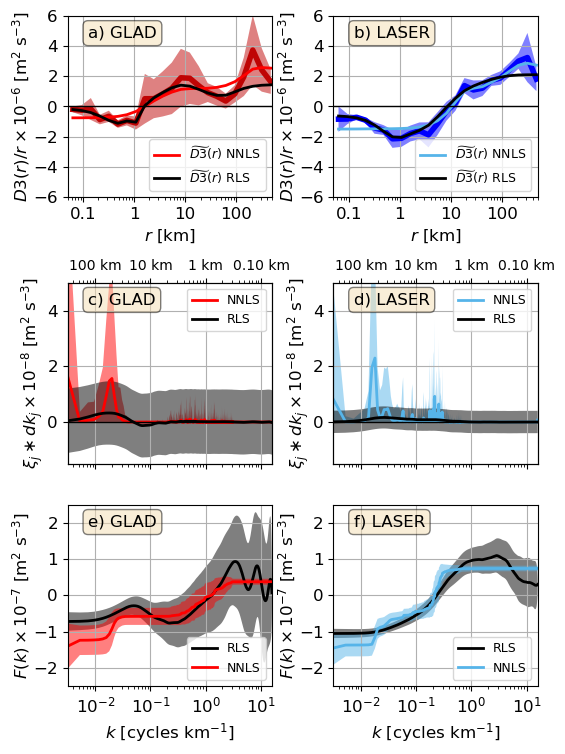

In [260]:
fig12, ax12 = plt.subplots(figsize=(5, 7))  # taller figure

ax12.set_visible(False)
# Increase height ratio for the second row to create extra space above it
gs = gridspec.GridSpec(
    4, 2,
    height_ratios=[1, 0.02, 1, 1],  # second row gets small height -> extra space above it
    hspace=0.3, wspace=0.3
)

ax12 = np.array([
    [fig12.add_subplot(gs[0, 0]), fig12.add_subplot(gs[0, 1])],
    [fig12.add_subplot(gs[1, 0]), fig12.add_subplot(gs[1, 1])],
    [fig12.add_subplot(gs[2, 0]), fig12.add_subplot(gs[2, 1])],
    [fig12.add_subplot(gs[3, 0]), fig12.add_subplot(gs[3, 1])]
])

# --- Panel a) GLAD ---
ax12[0, 0].semilogx(dist_all*1e-3, glad_D3b_mean/dist_all*1e7, '#BF0404', linewidth=4)
ax12[0, 0].fill_between(dist_all*1e-3, (glad_D3b_mean - glad_D3b_std)/dist_all*1e7, 
                        (glad_D3b_mean + glad_D3b_std)/dist_all*1e7,
                        alpha=0.5, color='#BF0404', edgecolor=None)
ax12[0, 0].semilogx(distkm, np.nanmean(V3_glad_nnls_mvbbstr, axis=0)*1e7, 
                    '-', color='red', label='$\\widetilde{D3}(r)$ NNLS', linewidth=2)
ax12[0, 0].semilogx(dist_all*1e-3, V3_glad_rls_mvb_logk/dist_all*1e7, '-', color='black', 
                    label='$\\widetilde{D3}(r)$ RLS', linewidth=2)
ax12[0, 0].set_ylabel('$D3(r)/r \\times 10^{-6}$ [m$^2$ s$^{-3}$]', fontsize=12, labelpad=1)
ax12[0, 0].text(0.1, 0.88, 'a) GLAD', transform=ax12[0, 0].transAxes, bbox=props, fontsize=12)
ax12[0, 0].tick_params(labelsize=12)
ax12[0, 0].set_yticks(np.arange(-6, 8, 2))
ax12[0, 0].set_ylim(-6, 6)
ax12[0, 0].set_xlim(0.5e-1, 5e2)
# ax12[0, 0].xaxis.set_label_position('top')
# ax12[0, 0].xaxis.tick_top()
ax12[0, 0].set_xlabel('$r$ [km]', fontsize=12)
ax12[0, 0].set_xticks([0.1, 1, 10, 100])
ax12[0, 0].set_xticklabels(['0.1', '1', '10', '100'])
ax12[0, 0].legend(fontsize=9, loc=4, ncol=1)
ax12[0, 0].grid()

# --- Panel b) LASER ---
ax12[0, 1].semilogx(dist_all*1e-3, laser_D3b_mean/dist_all*1e7, color='blue', linewidth=4)
ax12[0, 1].fill_between(dist_all*1e-3, (laser_D3b_mean - laser_D3b_std)/dist_all*1e7, 
                        (laser_D3b_mean + laser_D3b_std)/dist_all*1e7,
                        alpha=0.5, color='blue', edgecolor=None)
ax12[0, 1].semilogx(dist_all*1e-3, np.nanmean(V3_laser_nnls_mvbbstr, axis=0)*1e7, 
                    '-', color='#56B4E9', label='$\\widetilde{D3}(r)$ NNLS', linewidth=2)
ax12[0, 1].semilogx(dist_all*1e-3, V3_laser_rls_mvb_logk/dist_all*1e7, '-', 
                    color='black', label='$\\widetilde{D3}(r)$ RLS', linewidth=2)
ax12[0, 1].set_xlabel('$r$ [km]', fontsize=12)
ax12[0, 1].set_ylabel('$D3(r)/r \\times 10^{-6}$ [m$^2$ s$^{-3}$]', fontsize=12, labelpad=1)
ax12[0, 1].tick_params(labelsize=12)
ax12[0, 1].set_yticks(np.arange(-6, 8, 2))
ax12[0, 1].set_ylim(-6, 6)
ax12[0, 1].set_xlim(0.5e-1, 5e2)
ax12[0, 1].text(0.1, 0.88, 'b) LASER', transform=ax12[0, 1].transAxes, bbox=props, fontsize=12)
# ax12[0, 1].xaxis.set_label_position('top')
# ax12[0, 1].xaxis.tick_top()
ax12[0, 1].set_xlabel('$r$ [km]', fontsize=12)
ax12[0, 1].set_xticks([0.1, 1, 10, 100])
ax12[0, 1].set_xticklabels(['0.1', '1', '10', '100'])
ax12[0, 1].legend(fontsize=9, loc=4, ncol=1)
ax12[0, 1].grid()

# --- Panel c) GLAD spectral ---
ax12[2, 0].semilogx(kbins_nn*1e3, np.nanmean(eps_glad_nnls_mvbbstr[:, 1:], axis=0)*1e8*dk_nn, '-', 
                    color='red', label='NNLS', linewidth=2)
ax12[2, 0].fill_between(kbins_nn*1e3, 1e8*erru_eps_glad_nnls_mvbbstr[1:]*dk_nn,
                       1e8*errl_eps_glad_nnls_mvbbstr[1:]*dk_nn, 
                       color='red', alpha=0.5, edgecolor=None)
ax12[2, 0].semilogx(kbins_mvb_logk*1e3, eps_glad_rls_mvb_logk[1:]*1e8*dk_mvb_logk, '-', 
                    color='black', label='RLS', linewidth=2)
ax12[2, 0].fill_between(kbins_mvb_logk*1e3, 1e8*(eps_glad_rls_mvb_logk[1:] - eps_err_glad_rls_mvb_logk[1:])*dk_mvb_logk,
                        1e8*(eps_glad_rls_mvb_logk[1:]+ (eps_err_glad_rls_mvb_logk[1:]))*dk_mvb_logk, 
                        color='black', alpha=0.5, edgecolor=None)
ax12[2, 0].set_ylabel('$\\xi_j \\ast dk_j\\times 10^{-8}$ [m$^2$ s$^{-3}$]', fontsize=12, labelpad=1)
ax12[2, 0].set_xticklabels([])
ax12[2, 0].tick_params(labelsize=12)
ax12[2, 0].text(0.1, 0.88, 'c) GLAD', transform=ax12[2, 0].transAxes, bbox=props, fontsize=12)
ax12[2, 0].legend(fontsize=9, loc=1, ncol=1)
ax12[2, 0].set_ylim(-1.5, 5)
ax12[2, 0].set_xlim(kbins_nn.min()*1e3, kbins_nn.max()*1e3)
ax12[2, 0].grid()

# --- Panel d) LASER spectral ---
ax12[2, 1].semilogx(kbins_nn*1e3, np.nanmean(eps_laser_nnls_mvbbstr[:, 1:], axis=0)*1e8*dk_nn, '-', 
                    color='#56B4E9', label='NNLS', linewidth=2)
ax12[2, 1].fill_between(kbins_nn*1e3, 1e8*erru_eps_laser_nnls_mvbbstr[1:]*dk_nn,
                        1e8*errl_eps_laser_nnls_mvbbstr[1:]*dk_nn, 
                        color='#56B4E9', alpha=0.5, edgecolor=None)
ax12[2, 1].semilogx(kbins_mvb_logk*1e3, eps_laser_rls_mvb_logk[1:]*1e8*dk_mvb_logk, '-', 
                    color='black', label='RLS', linewidth=2)
ax12[2, 1].fill_between(kbins_mvb_logk*1e3, 1e8*(eps_laser_rls_mvb_logk[1:] - eps_err_laser_rls_mvb_logk[1:])*dk_mvb_logk,
                        1e8*(eps_laser_rls_mvb_logk[1:]+ (eps_err_laser_rls_mvb_logk[1:]))*dk_mvb_logk, 
                        color='black', alpha=0.5, edgecolor=None)
ax12[2, 1].set_ylabel('$\\xi_j \\ast dk_j\\times 10^{-8}$ [m$^2$ s$^{-3}$]', fontsize=12, labelpad=1)
ax12[2, 1].tick_params(labelsize=12)
ax12[2, 1].text(0.1, 0.88, 'd) LASER', transform=ax12[2, 1].transAxes, bbox=props, fontsize=12)
ax12[2, 1].legend(fontsize=9, loc=1, ncol=1)
ax12[2, 1].set_ylim(-1.5, 5)
ax12[2, 1].set_xlim(kbins_nn.min()*1e3, kbins_nn.max()*1e3)
ax12[2, 1].set_xticklabels([])
ax12[2, 1].grid()

# --- Panel e) GLAD flux ---
ax12[3, 0].semilogx(kbins_mvb_logk*1e3, fk_glad_rls_mvb_logk*1e7, '-', 
                    color='black', label='RLS', linewidth=2)
ax12[3, 0].fill_between(kbins_mvb_logk*1e3, 1e7*(fk_glad_rls_mvb_logk + fk_err_glad_rls_mvb_logk), 
                        1e7*(fk_glad_rls_mvb_logk - fk_err_glad_rls_mvb_logk),
                        color='black', alpha=0.5, edgecolor=None)
ax12[3, 0].semilogx(kbins_nn*1e3, 1e7*np.nanmean(Fk_glad_nnls_mvbbstr, axis=0), '-', 
                    color='red', label='NNLS', linewidth=2)
ax12[3, 0].fill_between(kbins_nn*1e3, 1e7*(np.nanmean(Fk_glad_nnls_mvbbstr, axis=0) + Fk_err_glad_nnls_mvbbstr),
                        1e7*(np.nanmean(Fk_glad_nnls_mvbbstr, axis=0) - Fk_err_glad_nnls_mvbbstr), 
                        color='red', alpha=0.5, edgecolor=None)
ax12[3, 0].set_ylabel('$F(k) \\times 10^{-7}$ [m$^2$ s$^{-3}$]', fontsize=12, labelpad=1)
ax12[3, 0].set_xlabel('$k$ [cycles km$^{-1}$]', fontsize=12)
ax12[3, 0].text(0.1, 0.88, 'e) GLAD', transform=ax12[3, 0].transAxes, bbox=props, fontsize=12)
ax12[3, 0].tick_params(labelsize=12)
ax12[3, 0].set_xlim(kbins_nn.min()*1e3, kbins_nn.max()*1e3)
ax12[3, 0].set_ylim(-2.5, 2.5)
ax12[3, 0].legend(fontsize=9, loc=4, ncol=1)
ax12[3, 0].grid()

# --- Panel f) LASER flux ---
ax12[3, 1].semilogx(kbins_mvb_logk*1e3, fk_laser_rls_mvb_logk*1e7, '-', 
                    color='black', label='RLS', linewidth=2)
ax12[3, 1].fill_between(kbins_mvb_logk*1e3, 1e7*(fk_laser_rls_mvb_logk + fk_err_laser_rls_mvb_logk), 
                        1e7*(fk_laser_rls_mvb_logk - fk_err_laser_rls_mvb_logk),
                        color='black', alpha=0.5, edgecolor=None)
ax12[3, 1].semilogx(kbins_nn*1e3, 1e7*np.nanmean(Fk_laser_nnls_mvbbstr, axis=0), '-', 
                    color='#56B4E9', label='NNLS', linewidth=2)
ax12[3, 1].fill_between(kbins_nn*1e3, 1e7*(np.nanmean(Fk_laser_nnls_mvbbstr, axis=0) + Fk_err_laser_nnls_mvbbstr),
                        1e7*(np.nanmean(Fk_laser_nnls_mvbbstr, axis=0) - Fk_err_laser_nnls_mvbbstr), 
                        color='#56B4E9', alpha=0.5, edgecolor=None)
ax12[3, 1].set_ylabel('$F(k) \\times 10^{-7}$ [m$^2$ s$^{-3}$]', fontsize=12, labelpad=1)
ax12[3, 1].set_xlabel('$k$ [cycles km$^{-1}$]', fontsize=12)
ax12[3, 1].text(0.1, 0.88, 'f) LASER', transform=ax12[3, 1].transAxes, bbox=props, fontsize=12)
ax12[3, 1].tick_params(labelsize=12)
ax12[3, 1].set_xlim(kbins_mvb_logk.min()*1e3, kbins_mvb_logk.max()*1e3)
ax12[3, 1].set_ylim(-2.5, 2.5)
ax12[3, 1].legend(fontsize=9, loc=4, ncol=1)
ax12[3, 1].grid()

# --- Top axes for panels c and e ---
k_ticks = np.array([1/1000.0, 1/100.0, 1/10.0, 1.0, 10.0])
ax_top_c = add_top_axis(ax12[2,0], k_ticks, unit='km')
ax_top_d = add_top_axis(ax12[2,1], k_ticks, unit='km')

# --- Zero line for all panels ---
for i in range(3):
    if i != 1:
        for j in range(2):
            ax12[i, j].axhline(0, color='k', linestyle='-', linewidth=1)

# Hide middle row axes
ax12[1, 0].set_visible(False)
ax12[1, 1].set_visible(False)


fig12.tight_layout(h_pad=-0.9)

In [ ]:
plt.pcolormesh(errorsFlux(cxx_glad_rls_mvb_logk, Herr_mvb_logk))

In [ ]:
plt.pcolormesh(cxx_glad_rls_mvb_logk)

In [ ]:
fig18, ax18 = plt.subplots(1, 3, figsize=(9, 3))

ax18[0].plot(np.concatenate(([1e-6], kbins_mvb_logk))*1e3, np.sort(eigval_cxx_glad_rls_mvb_logk), '.-r')
ax18[0].plot(np.concatenate(([1e-6], kbins_mvb_logk))*1e3, np.sort(eigval_cxx_laser_rls_mvb_logk), '.-b')
ax18[0].set_xscale('log')
ax18[0].set_ylabel('Eigenvalues')
ax18[0].set_xlabel('$k$')

ax18[1].semilogx(np.concatenate(([1e-6], kbins_mvb_logk))*1e3, eigvec_cxx_glad_rls_mvb_logk[:, :3], '-', alpha=0.5)
ax18[1].semilogx(np.concatenate(([1e-6], kbins_mvb_logk))*1e3, eigvec_cxx_glad_rls_mvb_logk[:, 6:10], '--')
ax18[1].semilogx(np.concatenate(([1e-6], kbins_mvb_logk))*1e3, eigvec_cxx_glad_rls_mvb_logk[:, -1], '-.')
ax18[1].set_ylabel('Eigenvectors')
ax18[1].set_xlabel('$k$')
ax18[1].set_title('GLAD')

ax18[2].semilogx(np.concatenate(([1e-6], kbins_mvb_logk))*1e3, eigvec_cxx_laser_rls_mvb_logk[:, :3], '-', alpha=0.5)
ax18[2].semilogx(np.concatenate(([1e-6], kbins_mvb_logk))*1e3, eigvec_cxx_laser_rls_mvb_logk[:, 6:10], '--')
ax18[2].semilogx(np.concatenate(([1e-6], kbins_mvb_logk))*1e3, eigvec_cxx_laser_rls_mvb_logk[:, -1], '-.')
ax18[2].set_ylabel('Eigenvectors')
ax18[2].set_xlabel('$k$')
ax18[2].set_title('LASER')

fig18.tight_layout()

In [ ]:
plt.semilogx(np.concatenate(([1e-6], kbins_mvb_logk))*1e3,eigval_cxx_glad_rls_mvb_logk.real)
plt.semilogx(np.concatenate(([1e-6], kbins_mvb_logk))*1e3,eigval_cxx_glad_rls_mvb_logk.imag)

In [ ]:
# Additional subplots for proposal
figP, axP = plt.subplots(1, 2, figsize=(6, 2.8))

# --- Panel a) -----------------------------------------------------------
axP[0].semilogx(dist_all * 1e-3, glad_D3b_mean / dist_all * 1e6, 'k', linewidth=3,
               label='Estimated')
axP[0].fill_between(dist_all * 1e-3,
                    (glad_D3b_mean - glad_D3b_std) / dist_all * 1e6,
                    (glad_D3b_mean + glad_D3b_std) / dist_all * 1e6,
                    alpha=0.5, color='black', edgecolor=None)
axP[0].semilogx(dist_all * 1e-3, V3_glad_rls_mvb_logk / dist_all * 1e6, '-r',
                label='RLS-fitted')
axP[0].semilogx(distkm, np.nanmean(V3_glad_nnls_mvbbstr, axis=0) * 1e6,
                '-', color='blue', label='NNLS-fitted')
axP[0].plot([0.5e-1, 5e2], [0, 0], '-k', linewidth=0.5)
axP[0].set_ylabel('$D3(r)/r \\times 10^{-6}$ [m$^2$ s$^{-3}$]', fontsize=12)
axP[0].set_xlabel('Distance $r$ [km]', fontsize=12)
# axP[0].set_xticklabels([])
axP[0].text(0.1, 0.88, 'a)', transform=axP[0].transAxes, bbox=props, fontsize=12)
axP[0].tick_params(labelsize=12)
axP[0].set_yticks(np.arange(-0.6, 0.8, 0.2))
axP[0].set_ylim(-0.6, 0.6)
axP[0].set_xlim(0.5e-1, 5e2)
axP[0].legend(fontsize=9, loc=4, ncol=1)
axP[0].grid()

# --- Panel b) -----------------------------------------------------------
axP[1].semilogx(kbins_mvb_logk * 1e3, fk_glad_rls_mvb_logk * 1e7, '-r', label='RLS')
axP[1].fill_between(kbins_mvb_logk * 1e3,
                    1e7 * (fk_glad_rls_mvb_logk + fk_err_glad_rls_mvb_logk),
                    1e7 * (fk_glad_rls_mvb_logk - fk_err_glad_rls_mvb_logk),
                    color='red', alpha=0.5, edgecolor=None)
axP[1].semilogx(kbins_nn * 1e3, 1e7 * np.nanmean(Fk_glad_nnls_mvbbstr, axis=0),
                '-', color='blue', label='NNLS')
axP[1].fill_between(kbins_nn * 1e3,
                    1e7 * (np.nanmean(Fk_glad_nnls_mvbbstr, axis=0) + Fk_err_glad_nnls_mvbbstr),
                    1e7 * (np.nanmean(Fk_glad_nnls_mvbbstr, axis=0) - Fk_err_glad_nnls_mvbbstr),
                    color='blue', alpha=0.3, edgecolor=None)
axP[1].plot([1e-3, 1e1], [0, 0], '-k', linewidth=0.5)
axP[1].set_ylabel('$F(k) \\times 10^{-7}$ [m$^2$ s$^{-3}$]', fontsize=12)
axP[1].set_xlabel('Wavenumber $k$ [cycles km$^{-1}$]', fontsize=12)
axP[1].text(0.1, 0.88, 'b)', transform=axP[1].transAxes, bbox=props, fontsize=12)
axP[1].text(1e-2, 2, 'Forward')
axP[1].text(1e-2, -2.3, 'Inverse')
axP[1].tick_params(labelsize=12)
axP[1].set_xlim(1e-3, 1e1)
axP[1].set_ylim(-3.5, 3.5)
axP[1].set_yticks(np.arange(-3, 4))
axP[1].legend(fontsize=9, loc=4, ncol=1)
axP[1].grid()

figP.tight_layout()
figP.savefig('./FiguresMethodsPaper/fig_proposal_Balwad2022.png', bbox_inches = 'tight', format='png', dpi=500)

In [289]:
# Compute global thresholds
def global_percentile_threshold(*arrays, p_low=5, p_high=95):
    combined = np.concatenate([a.ravel() for a in arrays])
    low, high = np.percentile(combined, [p_low, p_high])
    return low, high

# Filter using global thresholds
def filter_global(data, low, high):
    return data[(data >= low) & (data <= high)]

# Function to calculate stats with global filtering
def calculate_filtstats(du_glad, du_laser, du2_glad, du2_laser, du3_glad, du3_laser):
    # Compute thresholds from *all* inputs combined
    low, high = global_percentile_threshold(
        du_glad, du_laser, du2_glad, du2_laser, du3_glad, du3_laser
    )

    # Apply same thresholds to all datasets
    du_glad = filter_global(du_glad, low, high)
    du_laser = filter_global(du_laser, low, high)
    du2_glad = filter_global(du2_glad, low, high)
    du2_laser = filter_global(du2_laser, low, high)
    du3_glad = filter_global(du3_glad, low, high)
    du3_laser = filter_global(du3_laser, low, high)

    glad_stats = {
        'mean': np.mean(du_glad),
        'std': np.std(du_glad),
        'skew': skew(du_glad),
        'kurt': kurtosis(du_glad, fisher=True)
    }
    
    laser_stats = {
        'mean': np.mean(du_laser),
        'std': np.std(du_laser),
        'skew': skew(du_laser),
        'kurt': kurtosis(du_laser, fisher=True)
    }

    glad_du2_stats = {
        'mean': np.mean(du2_glad),
        'std': np.std(du2_glad),
        'skew': skew(du2_glad),
        'kurt': kurtosis(du2_glad, fisher=True)
    }

    laser_du2_stats = {
        'mean': np.mean(du2_laser),
        'std': np.std(du2_laser),
        'skew': skew(du2_laser),
        'kurt': kurtosis(du2_laser, fisher=True)
    }

    glad_du3_stats = {
        'mean': np.mean(du3_glad),
        'std': np.std(du3_glad),
        'skew': skew(du3_glad),
        'kurt': kurtosis(du3_glad, fisher=True)
    }

    laser_du3_stats = {
        'mean': np.mean(du3_laser),
        'std': np.std(du3_laser),
        'skew': skew(du3_laser),
        'kurt': kurtosis(du3_laser, fisher=True)
    }

    return glad_stats, laser_stats, glad_du2_stats, laser_du2_stats, glad_du3_stats, laser_du3_stats


# Parallelize per index (same as before)
def process_filtindex(ii):
    du_glad = glad_dul[ii] + glad_dut[ii]
    du_laser = laser_dul[ii] + laser_dut[ii]
    
    du2_glad, du3_glad = SF2_3(glad_dul[ii], glad_dut[ii])
    du2_laser, du3_laser = SF2_3(laser_dul[ii], laser_dut[ii])

    return calculate_filtstats(du_glad, du_laser, du2_glad, du2_laser, du3_glad, du3_laser)


In [290]:
# --- Parallel run (percentile-filtered) ---
num_cores = 6  # use all available cores
results_pctl = Parallel(n_jobs=num_cores, backend="threading")(
    delayed(process_filtindex)(ii) for ii in tqdm(range(len(dist_all)))
)

# Unzip once
results_pctl = list(zip(*results_pctl))
(
    glad_stats_all_pctl, laser_stats_all_pctl,
    glad_du2_stats_all_pctl, laser_du2_stats_all_pctl,
    glad_du3_stats_all_pctl, laser_du3_stats_all_pctl
) = results_pctl


def stack_filtstats(stats_list):
    """Convert list of dicts to stacked arrays: mean, std, skew, kurt"""
    return np.stack([s['mean'] for s in stats_list]), \
           np.stack([s['std'] for s in stats_list]), \
           np.stack([s['skew'] for s in stats_list]), \
           np.stack([s['kurt'] for s in stats_list])


# --- Extract into arrays (percentile-filtered) ---
glad_du_mean_pctl, glad_du_std_pctl, glad_du_skew_pctl, glad_du_kurt_pctl = stack_filtstats(glad_stats_all_pctl)
laser_du_mean_pctl, laser_du_std_pctl, laser_du_skew_pctl, laser_du_kurt_pctl = stack_filtstats(laser_stats_all_pctl)

glad_du2_mean_pctl, glad_du2_std_pctl, glad_du2_skew_pctl, glad_du2_kurt_pctl = stack_filtstats(glad_du2_stats_all_pctl)
laser_du2_mean_pctl, laser_du2_std_pctl, laser_du2_skew_pctl, laser_du2_kurt_pctl = stack_filtstats(laser_du2_stats_all_pctl)

glad_du3_mean_pctl, glad_du3_std_pctl, glad_du3_skew_pctl, glad_du3_kurt_pctl = stack_filtstats(glad_du3_stats_all_pctl)
laser_du3_mean_pctl, laser_du3_std_pctl, laser_du3_skew_pctl, laser_du3_kurt_pctl = stack_filtstats(laser_du3_stats_all_pctl)


  0%|          | 0/23 [00:00<?, ?it/s]

In [305]:
# --- IQR-based filtering (remove outliers) ---
def global_iqr_threshold(*arrays, whisker=1.5):
    combined = np.concatenate([a.ravel() for a in arrays])
    q1, q3 = np.percentile(combined, [25, 75])
    iqr = q3 - q1
    low, high = q1 - whisker * iqr, q3 + whisker * iqr
    return low, high

def filter_global_iqr(data, low, high):
    return data[(data >= low) & (data <= high)]

# Function to calculate stats with global IQR filtering
def calculate_qtlstats(du_glad, du_laser, du2_glad, du2_laser, du3_glad, du3_laser):
    # Compute thresholds from *all* inputs combined
    low, high = global_iqr_threshold(
        du_glad, du_laser, du2_glad, du2_laser, du3_glad, du3_laser
    )

    # Apply same thresholds to all datasets
    du_glad = filter_global_iqr(du_glad, low, high)
    du_laser = filter_global_iqr(du_laser, low, high)
    du2_glad = filter_global_iqr(du2_glad, low, high)
    du2_laser = filter_global_iqr(du2_laser, low, high)
    du3_glad = filter_global_iqr(du3_glad, low, high)
    du3_laser = filter_global_iqr(du3_laser, low, high)

    glad_stats = {
        'mean': np.mean(du_glad),
        'std': np.std(du_glad),
        'skew': skew(du_glad),
        'kurt': kurtosis(du_glad, fisher=True)
    }
    
    laser_stats = {
        'mean': np.mean(du_laser),
        'std': np.std(du_laser),
        'skew': skew(du_laser),
        'kurt': kurtosis(du_laser, fisher=True)
    }

    glad_du2_stats = {
        'mean': np.mean(du2_glad),
        'std': np.std(du2_glad),
        'skew': skew(du2_glad),
        'kurt': kurtosis(du2_glad, fisher=True)
    }

    laser_du2_stats = {
        'mean': np.mean(du2_laser),
        'std': np.std(du2_laser),
        'skew': skew(du2_laser),
        'kurt': kurtosis(du2_laser, fisher=True)
    }

    glad_du3_stats = {
        'mean': np.mean(du3_glad),
        'std': np.std(du3_glad),
        'skew': skew(du3_glad),
        'kurt': kurtosis(du3_glad, fisher=True)
    }

    laser_du3_stats = {
        'mean': np.mean(du3_laser),
        'std': np.std(du3_laser),
        'skew': skew(du3_laser),
        'kurt': kurtosis(du3_laser, fisher=True)
    }

    return glad_stats, laser_stats, glad_du2_stats, laser_du2_stats, glad_du3_stats, laser_du3_stats


# Parallelize per index (IQR filtered)
def process_qtlindex(ii):
    du_glad = glad_dul[ii] + glad_dut[ii]
    du_laser = laser_dul[ii] + laser_dut[ii]
    
    du2_glad, du3_glad = SF2_3(glad_dul[ii], glad_dut[ii])
    du2_laser, du3_laser = SF2_3(laser_dul[ii], laser_dut[ii])

    return calculate_qtlstats(du_glad, du_laser, du2_glad, du2_laser, du3_glad, du3_laser)

In [306]:
# --- Parallel run (IQR filtered) ---
num_cores = 6
results_qtl = Parallel(n_jobs=num_cores, backend="threading")(
    delayed(process_qtlindex)(ii) for ii in tqdm(range(len(dist_all)))
)

# Unzip once
results_qtl = list(zip(*results_qtl))
(
    glad_stats_all_qtl, laser_stats_all_qtl,
    glad_du2_stats_all_qtl, laser_du2_stats_all_qtl,
    glad_du3_stats_all_qtl, laser_du3_stats_all_qtl
) = results_qtl


def stack_qtlstats(stats_list):
    """Convert list of dicts to stacked arrays: mean, std, skew, kurt"""
    return np.stack([s['mean'] for s in stats_list]), \
           np.stack([s['std'] for s in stats_list]), \
           np.stack([s['skew'] for s in stats_list]), \
           np.stack([s['kurt'] for s in stats_list])


# --- Extract into arrays (IQR filtered) ---
glad_du_mean_qtl, glad_du_std_qtl, glad_du_skew_qtl, glad_du_kurt_qtl = stack_qtlstats(glad_stats_all_qtl)
laser_du_mean_qtl, laser_du_std_qtl, laser_du_skew_qtl, laser_du_kurt_qtl = stack_qtlstats(laser_stats_all_qtl)

glad_du2_mean_qtl, glad_du2_std_qtl, glad_du2_skew_qtl, glad_du2_kurt_qtl = stack_qtlstats(glad_du2_stats_all_qtl)
laser_du2_mean_qtl, laser_du2_std_qtl, laser_du2_skew_qtl, laser_du2_kurt_qtl = stack_qtlstats(laser_du2_stats_all_qtl)

glad_du3_mean_qtl, glad_du3_std_qtl, glad_du3_skew_qtl, glad_du3_kurt_qtl = stack_qtlstats(glad_du3_stats_all_qtl)
laser_du3_mean_qtl, laser_du3_std_qtl, laser_du3_skew_qtl, laser_du3_kurt_qtl = stack_qtlstats(laser_du3_stats_all_qtl)

  0%|          | 0/23 [00:00<?, ?it/s]

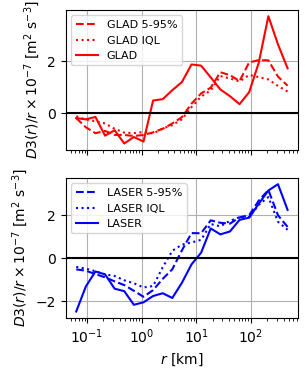

In [308]:
plt.figure(figsize=(3,4))
plt.subplot(2,1,1)
plt.semilogx(dist_all*1e-3, glad_du3_mean_pctl/dist_all*1e7, '--r', label='GLAD 5-95%')
plt.semilogx(dist_all*1e-3, glad_du3_mean_qtl/dist_all*1e7, ':r', label='GLAD IQL')
plt.semilogx(dist_all*1e-3, glad_du3_mean/dist_all*1e7, '-r', label='GLAD')
plt.axhline(0, color='k', linestyle='-')
plt.ylabel('$D3(r)/r \\times 10^{-7}$ [m$^2$ s$^{-3}$]')
plt.gca().set_xticklabels([])
plt.grid()
plt.legend(fontsize=8)

plt.subplot(2,1,2)
plt.semilogx(dist_all*1e-3, laser_du3_mean_pctl/dist_all*1e7, '--b', label='LASER 5-95%')
plt.semilogx(dist_all*1e-3, laser_du3_mean_qtl/dist_all*1e7, ':b', label='LASER IQL')
plt.semilogx(dist_all*1e-3, laser_du3_mean/dist_all*1e7, '-b', label='LASER')
plt.axhline(0, color='k', linestyle='-')
plt.xlabel('$r$ [km]')
plt.ylabel('$D3(r)/r \\times 10^{-7}$ [m$^2$ s$^{-3}$]')
plt.grid()
plt.legend(fontsize=8)
